# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
from api_key_store import ApiKeyStore
s = ApiKeyStore()
api_key = s.get_api_key("OPENAI/Yiwen")
# print(openai_api_key)

In [2]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

# from vanna.ollama import Ollama
from vanna.openai import OpenAI_Chat
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [3]:
model_name = "gpt-4o-mini" # "gpt-4o" # 'gpt-4'  # 'gpt-3.5-turbo'
file_db = "~/Downloads/chinook.sqlite"

CONFIG = {
    'model': model_name,   # 'mistral' # "starcoder2"
    'api_key': api_key,     
}

file_db = "~/Downloads/datasets/chinook.db"

clean_and_train = True  # False  

sql_id = 1
NUM_RETRY = 3

In [4]:
class MyVanna(ChromaDB_VectorStore, OpenAI_Chat):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        OpenAI_Chat.__init__(self, config=config)
        

In [5]:
def remove_collections(collection_name=None, ACCEPTED_TYPES = ["sql", "ddl", "documentation"]):
    if not collection_name:
        collections = ACCEPTED_TYPES
    elif isinstance(collection_name, str):
        collections = [collection_name]
    elif isinstance(collection_name, list):
        collections = collection_name
    else:
        print(f"\t{collection_name} is unknown: Skipped")
        return

    for c in collections:
        if not c in ACCEPTED_TYPES:
            print(f"\t{c} is unknown: Skipped")
            continue
            
        # print(f"vn.remove_collection('{c}')")
        vn.remove_collection(c)

def strip_brackets(ddl):
    """
    This function removes square brackets from table and column names in a DDL script.
    
    Args:
        ddl (str): The DDL script containing square brackets.
    
    Returns:
        str: The DDL script with square brackets removed.
    """
    # Use regular expressions to match and replace square brackets
    pattern = r"\[([^\]]+)]"  # Match any character except ] within square brackets
    return re.sub(pattern, r"\1", ddl)

In [6]:
vn = MyVanna(config=CONFIG)

In [7]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: ducklover1


In [8]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [9]:
vn.run_sql_is_set

True

In [10]:
if clean_and_train:
    remove_collections()

## Training
You only need to train once. Do not train again unless you want to add more training data.

In [11]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type


In [12]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [13]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [14]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

Adding ddl: CREATE TABLE "albums"
(
    AlbumId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Title NVARCHAR(160)  NOT NULL,
    ArtistId INTEGER  NOT NULL,
    FOREIGN KEY (ArtistId) REFERENCES "artists" (ArtistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TABLE sqlite_sequence(name,seq)
Adding ddl: CREATE TABLE "artists"
(
    ArtistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)
Adding ddl: CREATE TABLE "customers"
(
    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    FirstName NVARCHAR(40)  NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    Company NVARCHAR(80),
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email NVARCHAR(60)  NOT NULL,
    SupportRepId INTEGER,
    FOREIGN KEY (SupportRepId) REFERENCES "employees" (EmployeeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TAB

## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up





# QUESTION :  How many customers are there


Using model gpt-4o-mini for 944.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT COUNT(*) AS CustomerCount FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS CustomerCount FROM customers;


[( <DataFrame> )]
queried dataframe



,CustomerCount
0,59


Using model gpt-4o-mini for 166.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

# Check if there is only one value in the dataframe
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['CustomerCount'].iloc[0],
        title={"text": "Total Customers"}
    ))
else:
    fig = go.Figure(data=[go.Bar(
        x=['Total Customers'],
        y=df['CustomerCount']
    )])

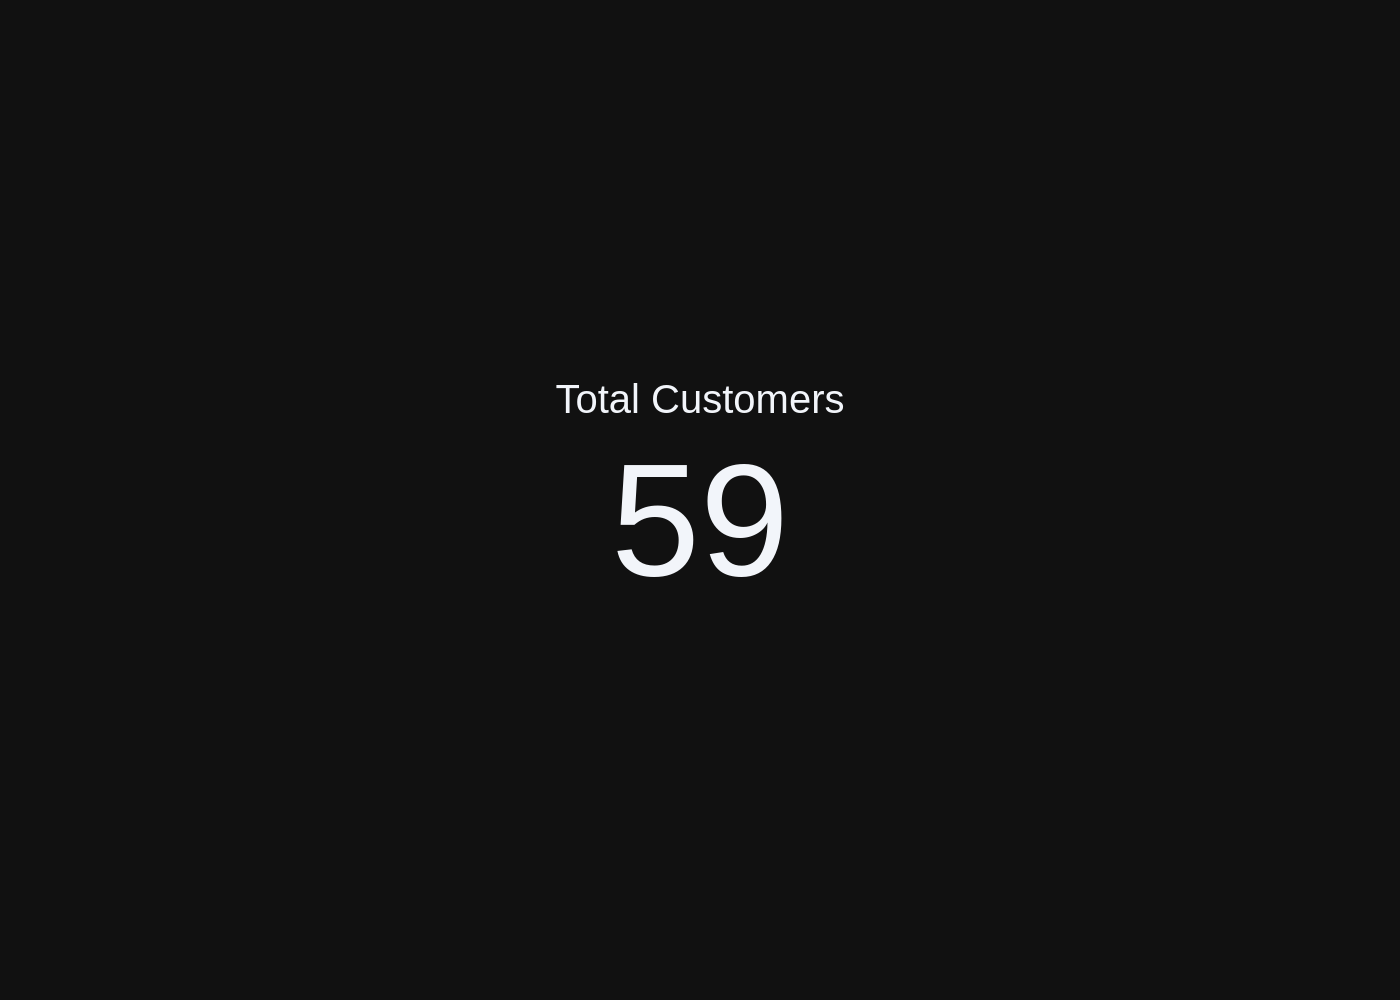

elapsed_time = 2.96726131439209


In [15]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

In [16]:
### Loop over questions

In [17]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?


Using model gpt-4o-mini for 866.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT name FROM sqlite_master WHERE type='table';


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master WHERE type='table';


[( <DataFrame> )]
queried dataframe



,name
0,albums
1,sqlite_sequence
2,artists
3,customers
4,employees
5,genres
6,invoices
7,invoice_items
8,media_types
9,playlists


Using model gpt-4o-mini for 172.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['name'][0],
        title={"text": "Table Name"}
    ))
else:
    fig = px.bar(df, x='name', y=df.index, title='Tables in SQLite Database', labels={'y': 'Index', 'name': 'Table Name'})

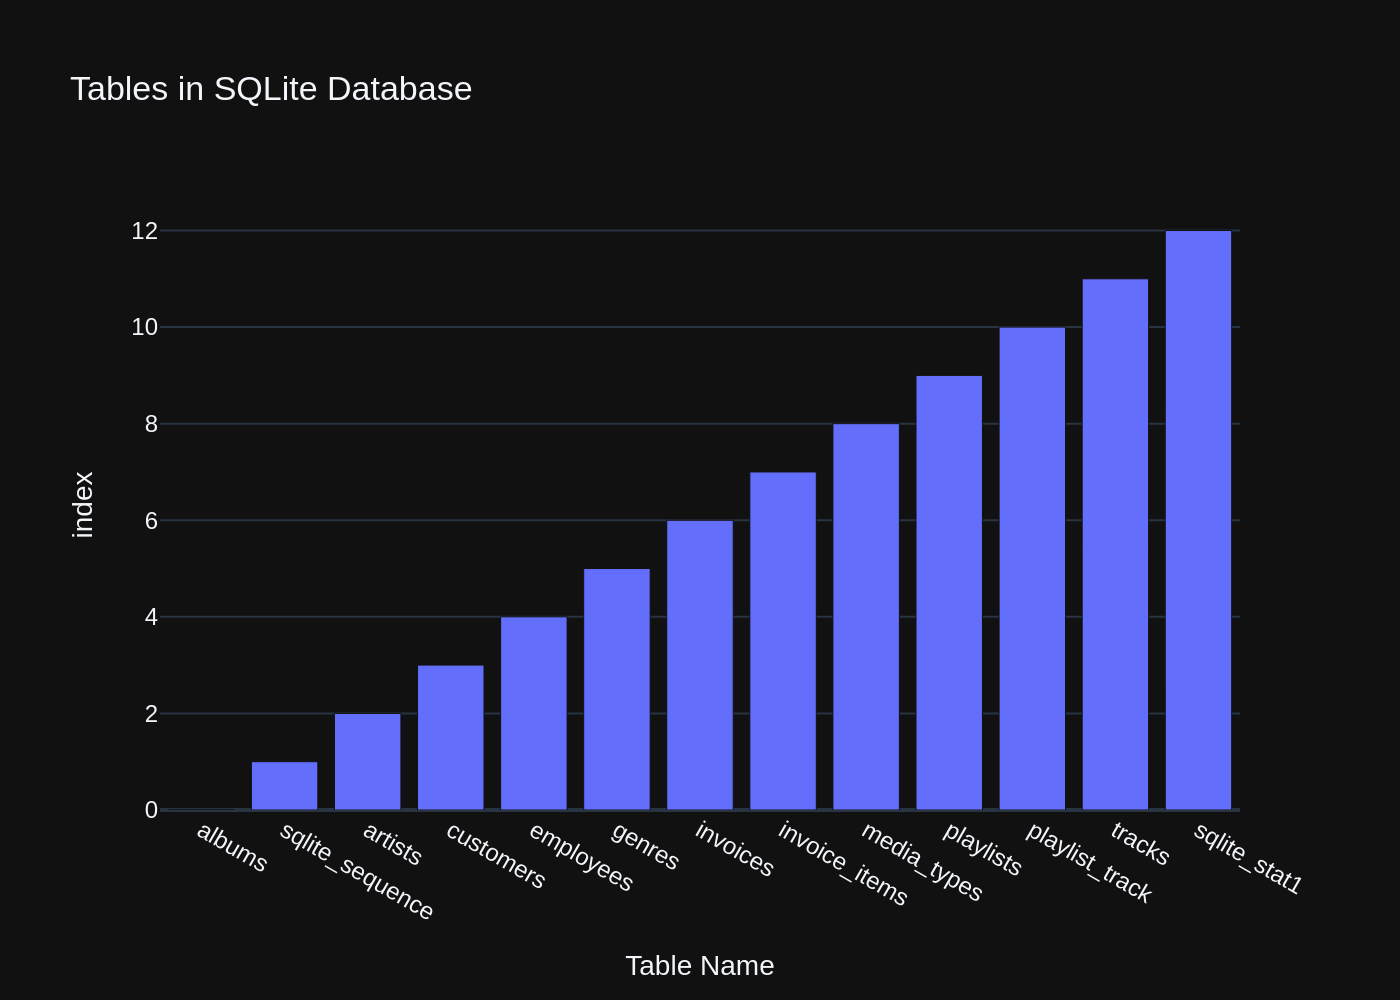





# QUESTION  - 3:  which table stores customer's orders


Using model gpt-4o-mini for 1075.0 tokens (approx)

[( RETRY )]
***** 1 *****

Using model gpt-4o-mini for 1063.5 tokens (approx)

[( EXTRACTED SQL )]
SELECT 'The table that stores customer''s orders is the "invoices" table.' AS Result;


[( <SQL> )]
generated SQL statement



SELECT 'The table that stores customer''s orders is the "invoices" table.' AS Result;


[( <DataFrame> )]
queried dataframe



,Result
0,The table that stores customer's orders is the...


Using model gpt-4o-mini for 263.25 tokens (approx)

[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.graph_objects as go

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=1,
        title={"text": df['Result'][0]}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df.index, y=[1]*len(df), text=df['Result'], textposition='auto')])

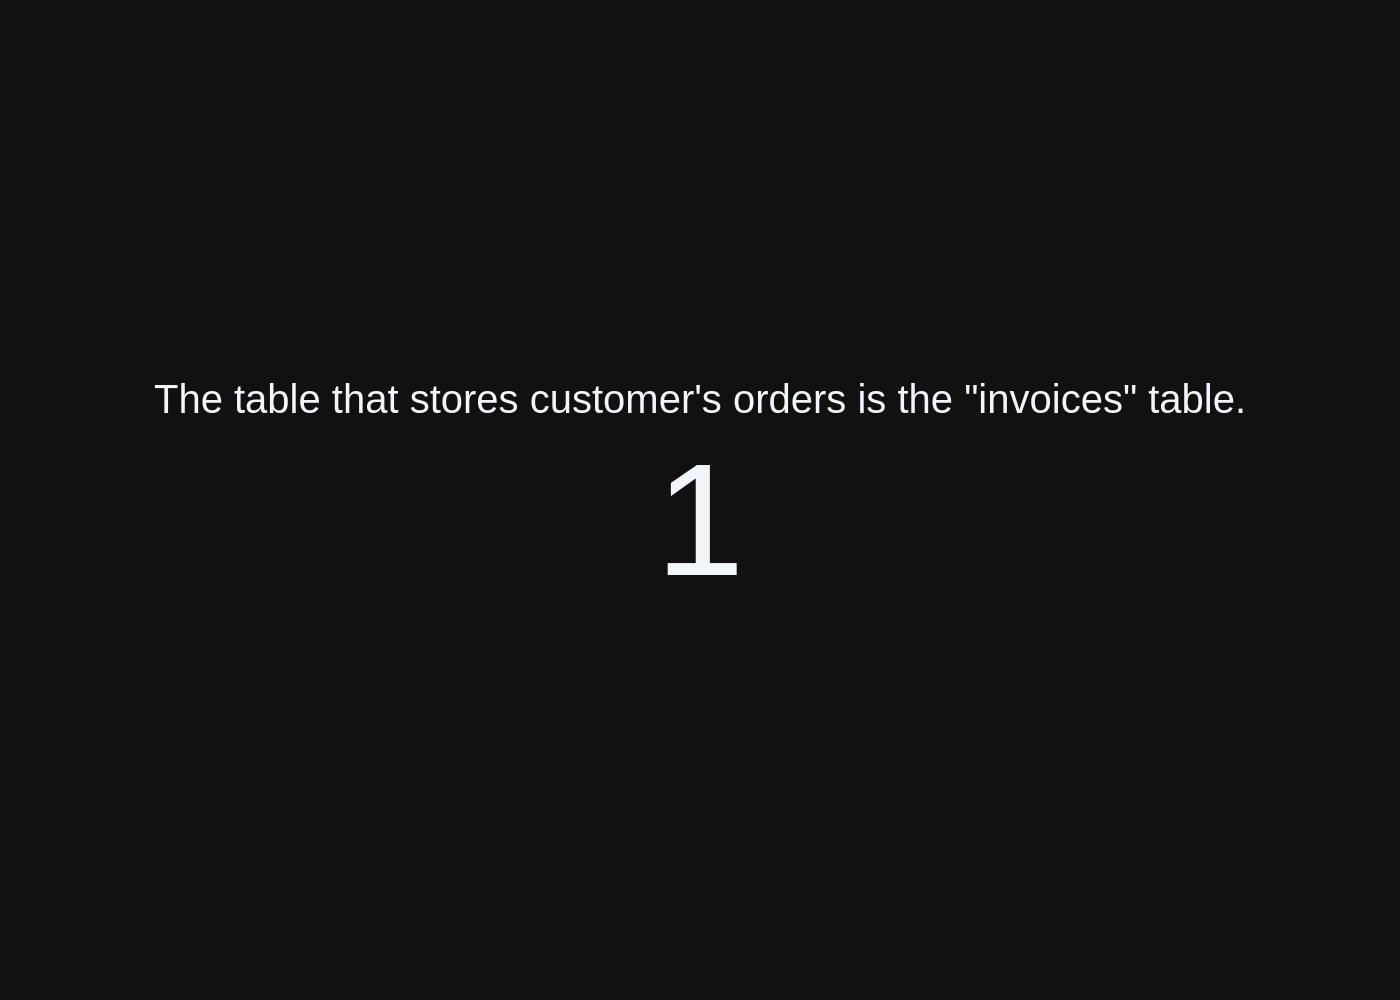





# QUESTION  - 4:  How many customers are there


Using model gpt-4o-mini for 1112.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT COUNT(*) AS CustomerCount FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS CustomerCount FROM customers;


[( <DataFrame> )]
queried dataframe



,CustomerCount
0,59


Using model gpt-4o-mini for 166.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

# Check if there is only one value in the dataframe
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['CustomerCount'].iloc[0],
        title={"text": "Total Customers"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = go.Figure(data=[go.Bar(
        x=['Total Customers'],
        y=df['CustomerCount']
    )])

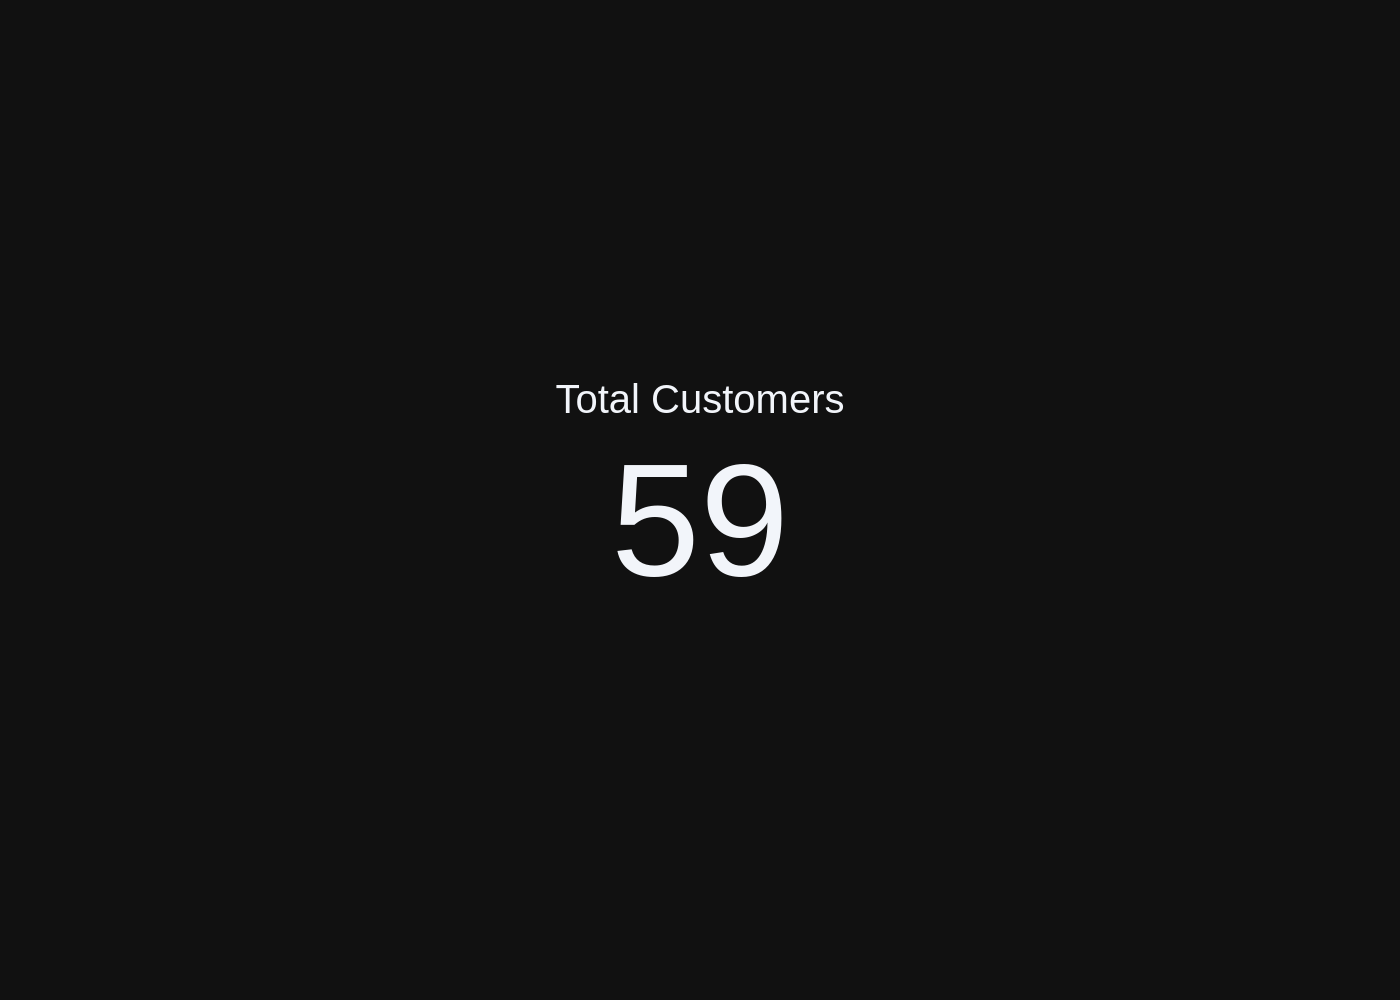





# QUESTION  - 5:  what are the top 5 countries that customers come from?


Using model gpt-4o-mini for 1337.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT BillingCountry, COUNT(*) AS CustomerCount 
FROM invoices 
GROUP BY BillingCountry 
ORDER BY CustomerCount DESC 
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT BillingCountry, COUNT(*) AS CustomerCount 
FROM invoices 
GROUP BY BillingCountry 
ORDER BY CustomerCount DESC 
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,BillingCountry,CustomerCount
0,USA,91
1,Canada,56
2,France,35
3,Brazil,35
4,Germany,28


Using model gpt-4o-mini for 197.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['CustomerCount'].iloc[0],
        title={"text": f"Top Country: {df['BillingCountry'].iloc[0]}"},
    ))
else:
    fig = px.bar(df, x='BillingCountry', y='CustomerCount', title='Top 5 Countries by Customer Count')

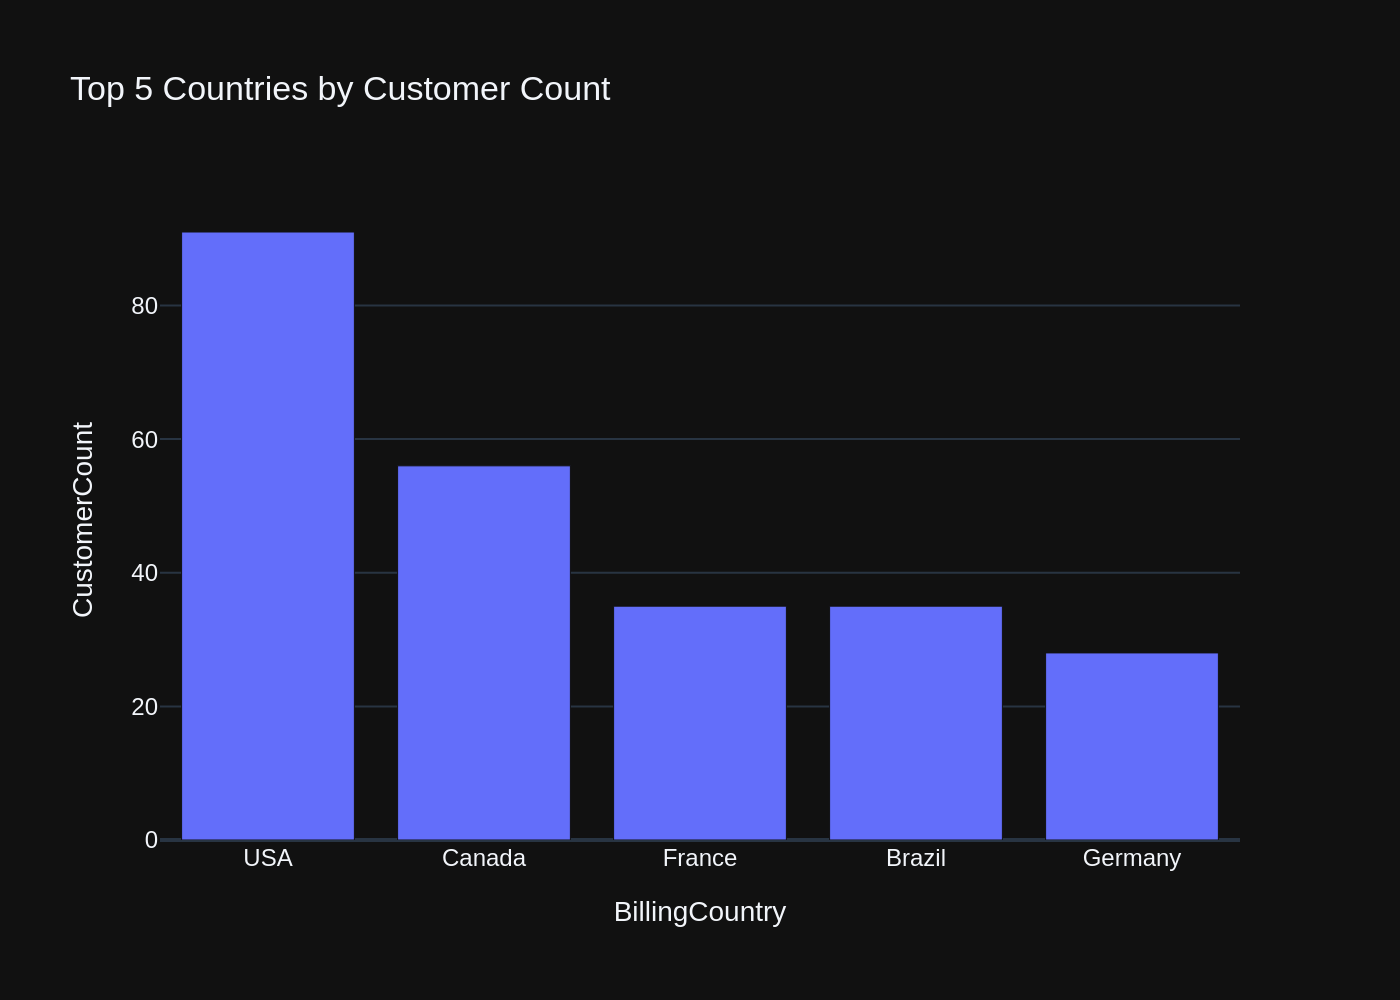





# QUESTION  - 6:  List all albums and their corresponding artist names  


Using model gpt-4o-mini for 873.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT albums.Title AS AlbumTitle, artists.Name AS ArtistName 
FROM albums 
JOIN artists ON albums.ArtistId = artists.ArtistId;


[( <SQL> )]
generated SQL statement



SELECT albums.Title AS AlbumTitle, artists.Name AS ArtistName 
FROM albums 
JOIN artists ON albums.ArtistId = artists.ArtistId;


[( <DataFrame> )]
queried dataframe



,AlbumTitle,ArtistName
0,For Those About To Rock We Salute You,AC/DC
1,Balls to the Wall,Accept
2,Restless and Wild,Accept
3,Let There Be Rock,AC/DC
4,Big Ones,Aerosmith
5,Jagged Little Pill,Alanis Morissette
6,Facelift,Alice In Chains
7,Warner 25 Anos,Antônio Carlos Jobim
8,Plays Metallica By Four Cellos,Apocalyptica
9,Audioslave,Audioslave


Using model gpt-4o-mini for 197.75 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=1,
        title={"text": f"Album: {df['AlbumTitle'].iloc[0]}<br>Artist: {df['ArtistName'].iloc[0]}"},
    ))
else:
    fig = px.bar(df, x='AlbumTitle', y='ArtistName', title='Albums and Artists', labels={'ArtistName': 'Artist Name', 'AlbumTitle': 'Album Title'})

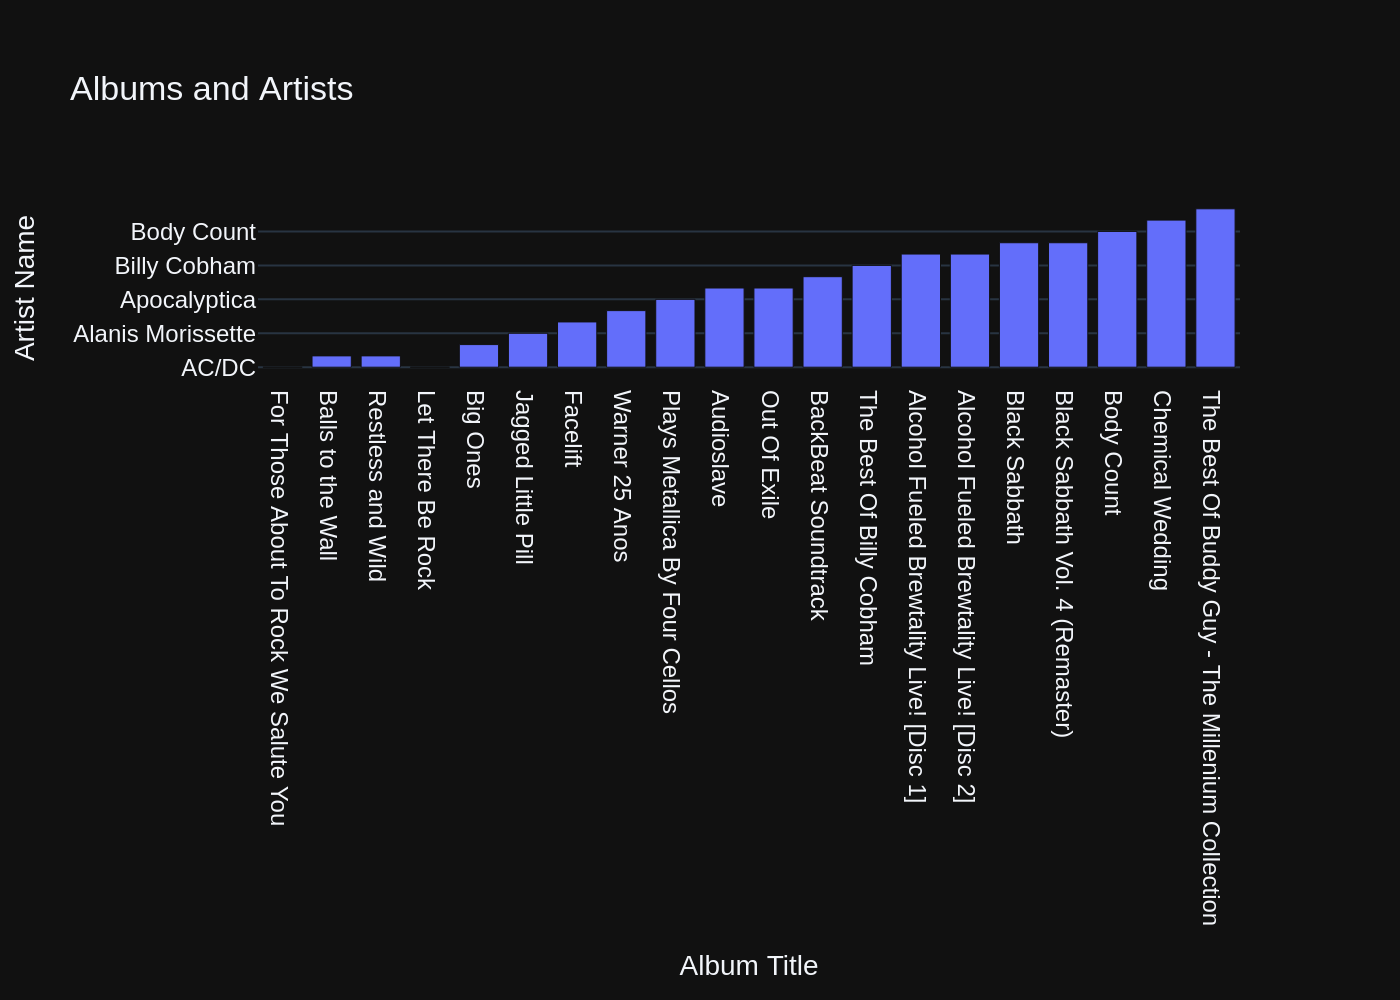





# QUESTION  - 7:  Find all tracks with a name containing "What" (case-insensitive) 


Using model gpt-4o-mini for 943.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT * FROM tracks WHERE Name LIKE '%What%' COLLATE NOCASE;


[( <SQL> )]
generated SQL statement



SELECT * FROM tracks WHERE Name LIKE '%What%' COLLATE NOCASE;


[( <DataFrame> )]
queried dataframe



,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,26,What It Takes,5,1,1,"Steven Tyler, Joe Perry, Desmond Child",310622,10144730,0.99
1,88,What You Are,10,1,1,Audioslave/Chris Cornell,249391,5988186,0.99
2,130,Do what cha wanna,13,1,2,George Duke,274155,9018565,0.99
3,342,What is and Should Never Be,30,1,1,Jimmy Page/Robert Plant,260675,8497116,0.99
4,607,So What,48,1,2,Miles Davis,564009,18360449,0.99
5,960,What A Day,76,1,1,"Mike Bordin, Billy Gould, Mike Patton",158275,5203430,0.99
6,1000,What If I Do?,80,1,1,"Dave Grohl, Taylor Hawkins, Nate Mendel, Chris...",302994,9929799,0.99
7,1039,What Now My Love,83,1,12,carl sigman/gilbert becaud/pierre leroyer,149995,4913383,0.99
8,1145,Whatsername,89,1,4,Green Day,252316,8244843,0.99
9,1440,"Whatever It Is, I Just Can't Stop",116,1,1,"Jay Kay/Kay, Jay",247222,8249453,0.99


Using model gpt-4o-mini for 227.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['TrackId'].iloc[0],
        title={"text": "Track ID"},
        delta={'reference': 0}
    ))
else:
    fig = px.bar(df, x='Name', y='UnitPrice', title='Tracks Containing "What"', labels={'UnitPrice': 'Price', 'Name': 'Track Name'})

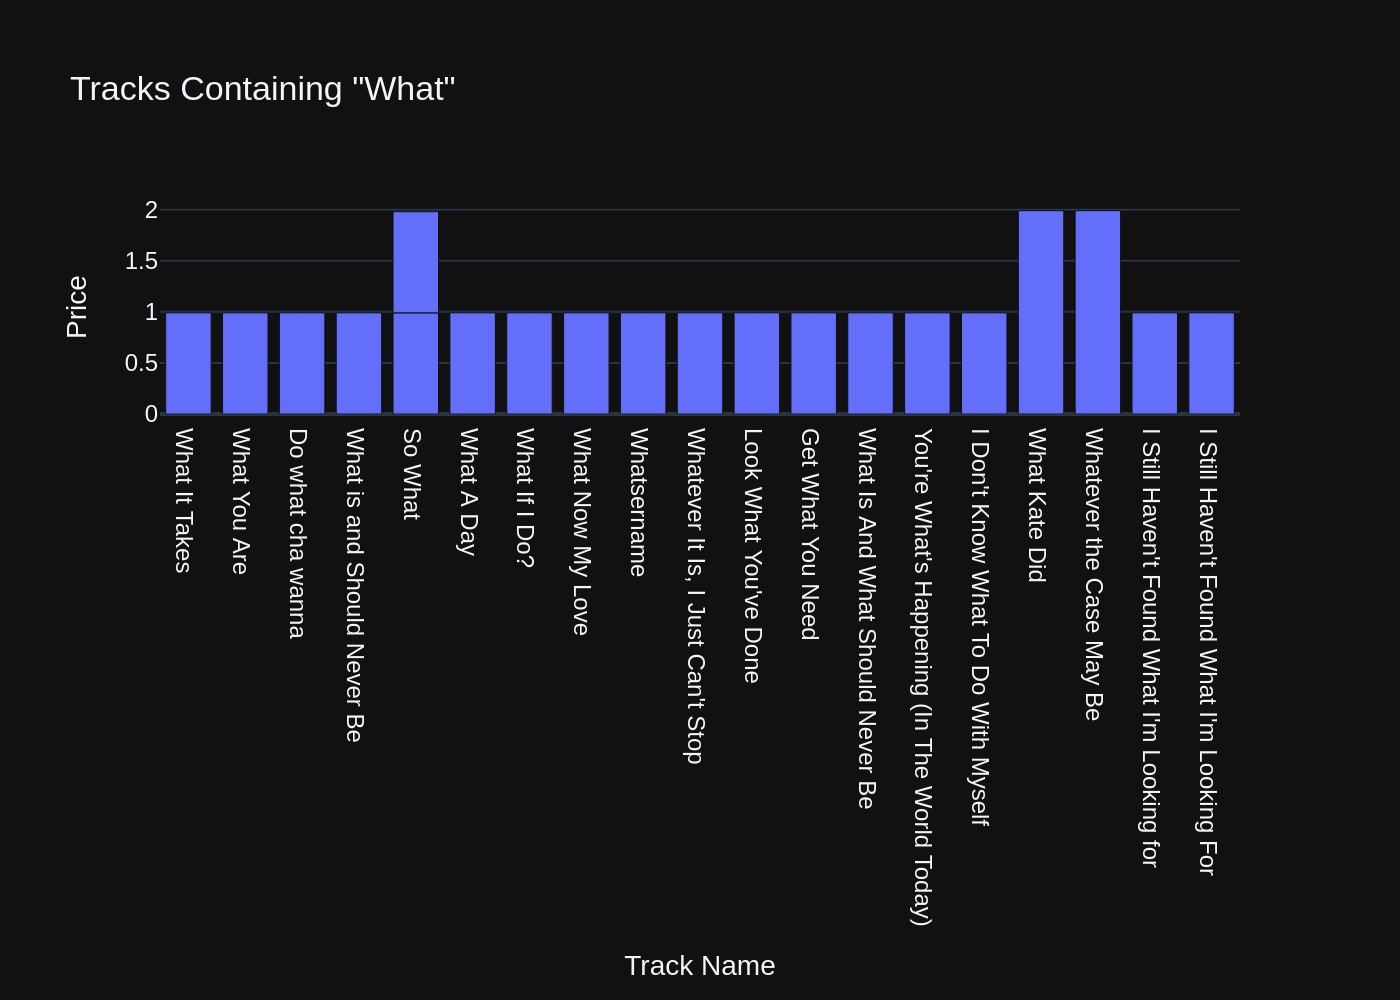





# QUESTION  - 8:  Get the total number of invoices for each customer


Using model gpt-4o-mini for 1327.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT CustomerId, COUNT(*) AS InvoiceCount 
FROM invoices 
GROUP BY CustomerId LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,InvoiceCount
0,1,7
1,2,7
2,3,7
3,4,7
4,5,7
5,6,7
6,7,7
7,8,7
8,9,7
9,10,7


Using model gpt-4o-mini for 185.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['InvoiceCount'].iloc[0],
        title={"text": f"Total Invoices for Customer {df['CustomerId'].iloc[0]}"}
    ))
else:
    fig = px.bar(df, x='CustomerId', y='InvoiceCount', title='Total Invoices for Each Customer', labels={'InvoiceCount': 'Invoice Count', 'CustomerId': 'Customer ID'})

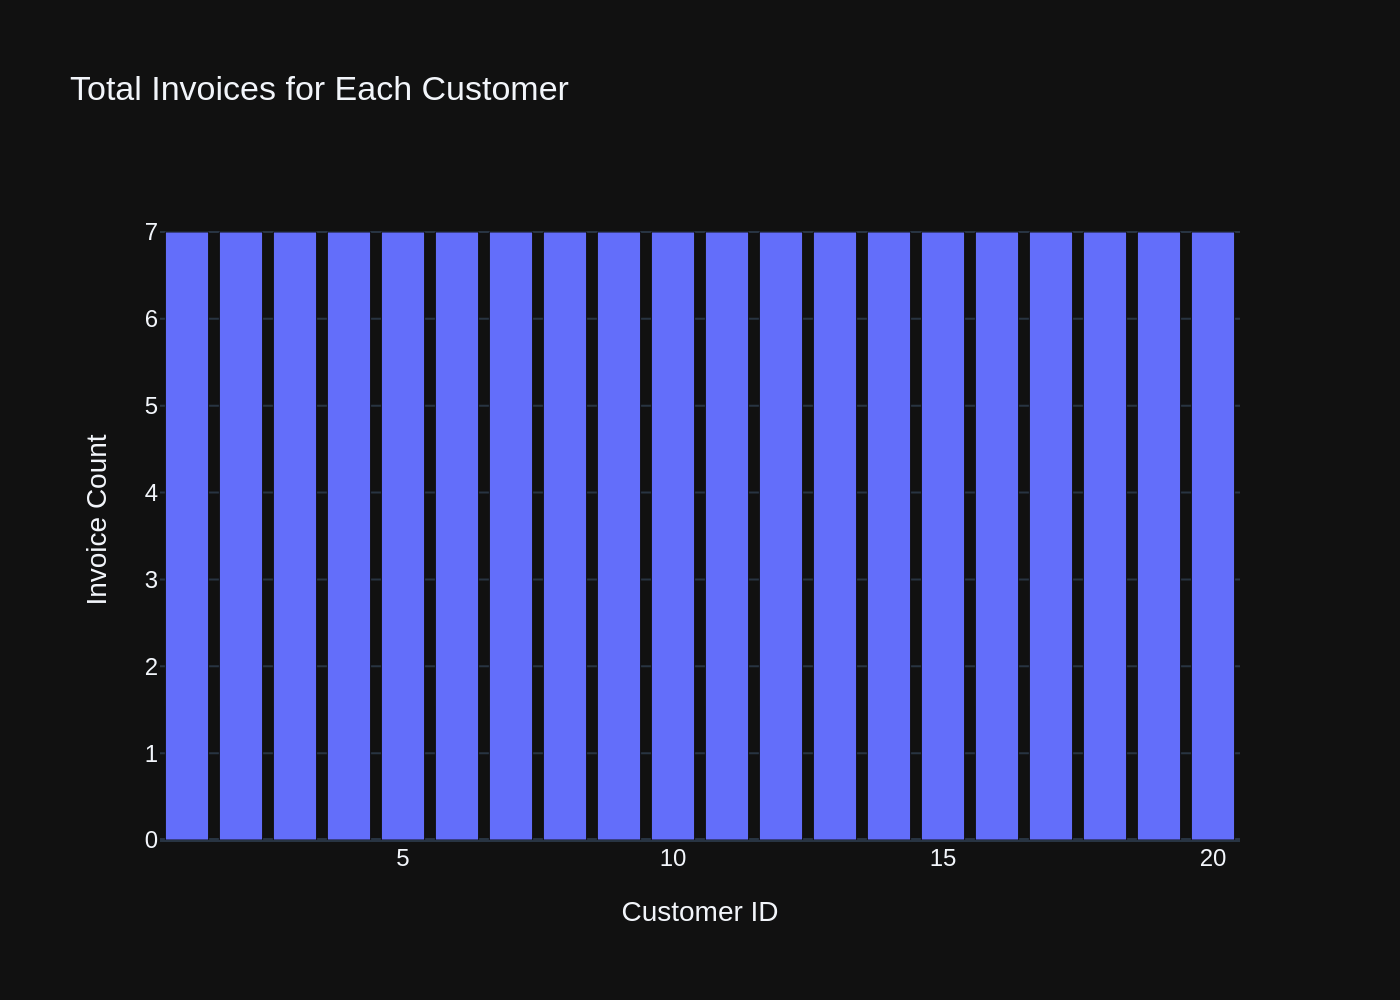





# QUESTION  - 9:  Find the total number of invoices per country


Using model gpt-4o-mini for 1408.25 tokens (approx)

[( EXTRACTED SQL )]
SELECT BillingCountry, COUNT(*) AS TotalInvoices 
FROM invoices 
GROUP BY BillingCountry;


[( <SQL> )]
generated SQL statement



SELECT BillingCountry, COUNT(*) AS TotalInvoices 
FROM invoices 
GROUP BY BillingCountry;


[( <DataFrame> )]
queried dataframe



,BillingCountry,TotalInvoices
0,Argentina,7
1,Australia,7
2,Austria,7
3,Belgium,7
4,Brazil,35
5,Canada,56
6,Chile,7
7,Czech Republic,14
8,Denmark,7
9,Finland,7


Using model gpt-4o-mini for 188.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['TotalInvoices'].iloc[0],
        title={"text": f"Total Invoices in {df['BillingCountry'].iloc[0]}"}
    ))
else:
    fig = px.bar(df, x='BillingCountry', y='TotalInvoices', title='Total Invoices per Country')

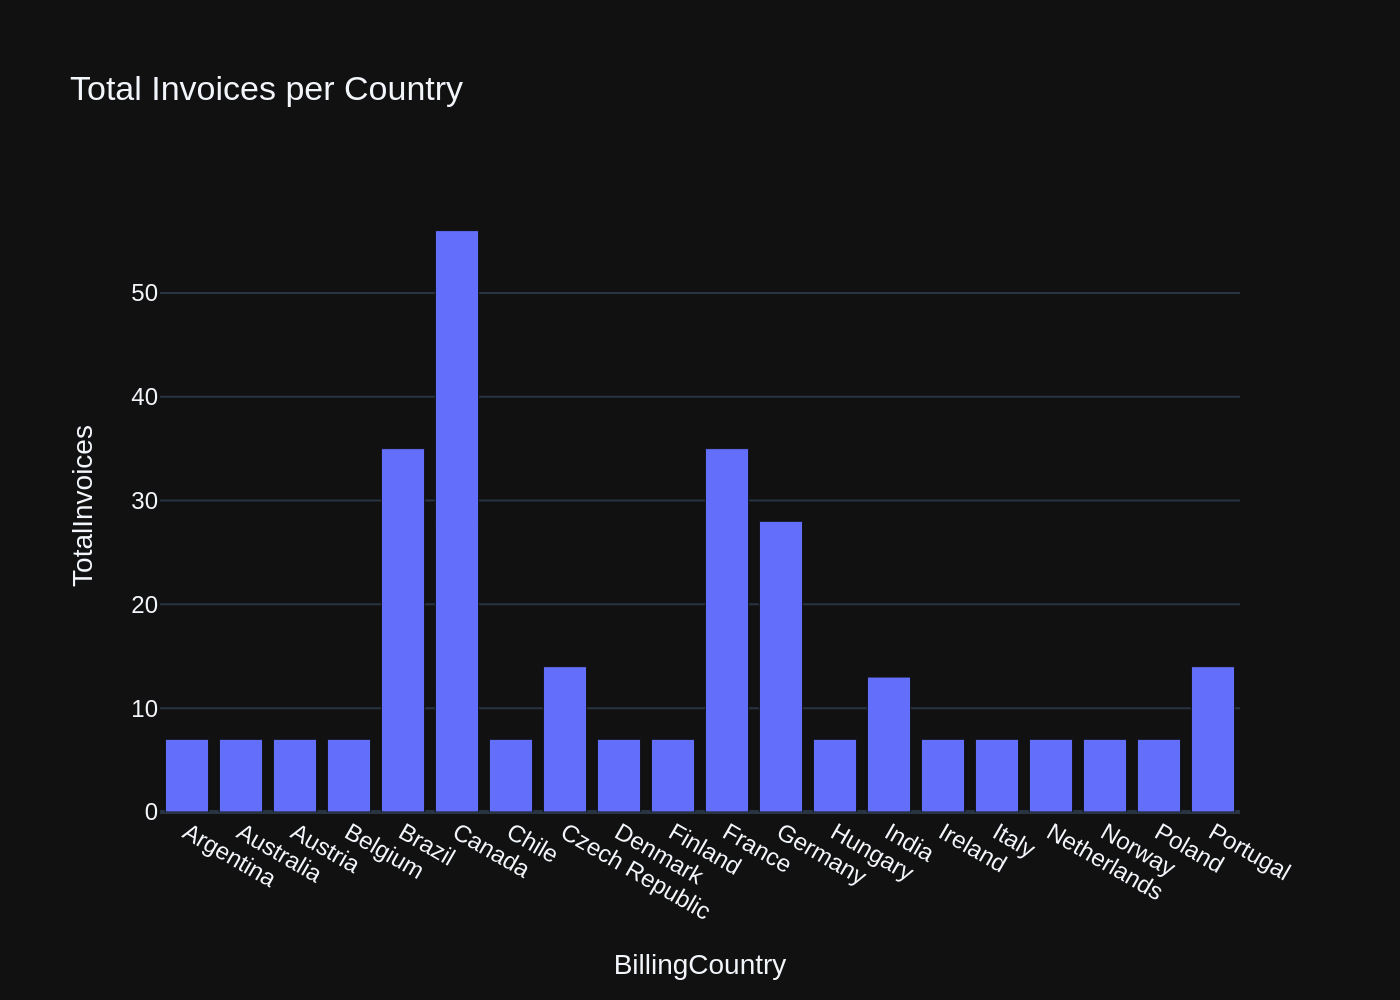





# QUESTION  - 10:  List all invoices with a total exceeding $10


Using model gpt-4o-mini for 1396.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * FROM invoices WHERE Total > 10.00 LIMIT 20


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86
1,12,2,2009-02-11 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,13.86
2,19,40,2009-03-14 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,13.86
3,26,19,2009-04-14 00:00:00,1 Infinite Loop,Cupertino,CA,USA,95014,13.86
4,33,57,2009-05-15 00:00:00,"Calle Lira, 198",Santiago,None,Chile,None,13.86
5,40,36,2009-06-15 00:00:00,Tauentzienstraße 8,Berlin,None,Germany,10789,13.86
6,47,15,2009-07-16 00:00:00,700 W Pender Street,Vancouver,BC,Canada,V6C 1G8,13.86
7,54,53,2009-08-16 00:00:00,113 Lupus St,London,None,United Kingdom,SW1V 3EN,13.86
8,61,32,2009-09-16 00:00:00,696 Osborne Street,Winnipeg,MB,Canada,R3L 2B9,13.86
9,68,11,2009-10-17 00:00:00,"Av. Paulista, 2022",São Paulo,SP,Brazil,01310-200,13.86


Using model gpt-4o-mini for 229.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['Total'].iloc[0],
        title={"text": "Total Invoice Amount"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = px.bar(df, x='InvoiceId', y='Total', title='Invoices with Total Exceeding $10')

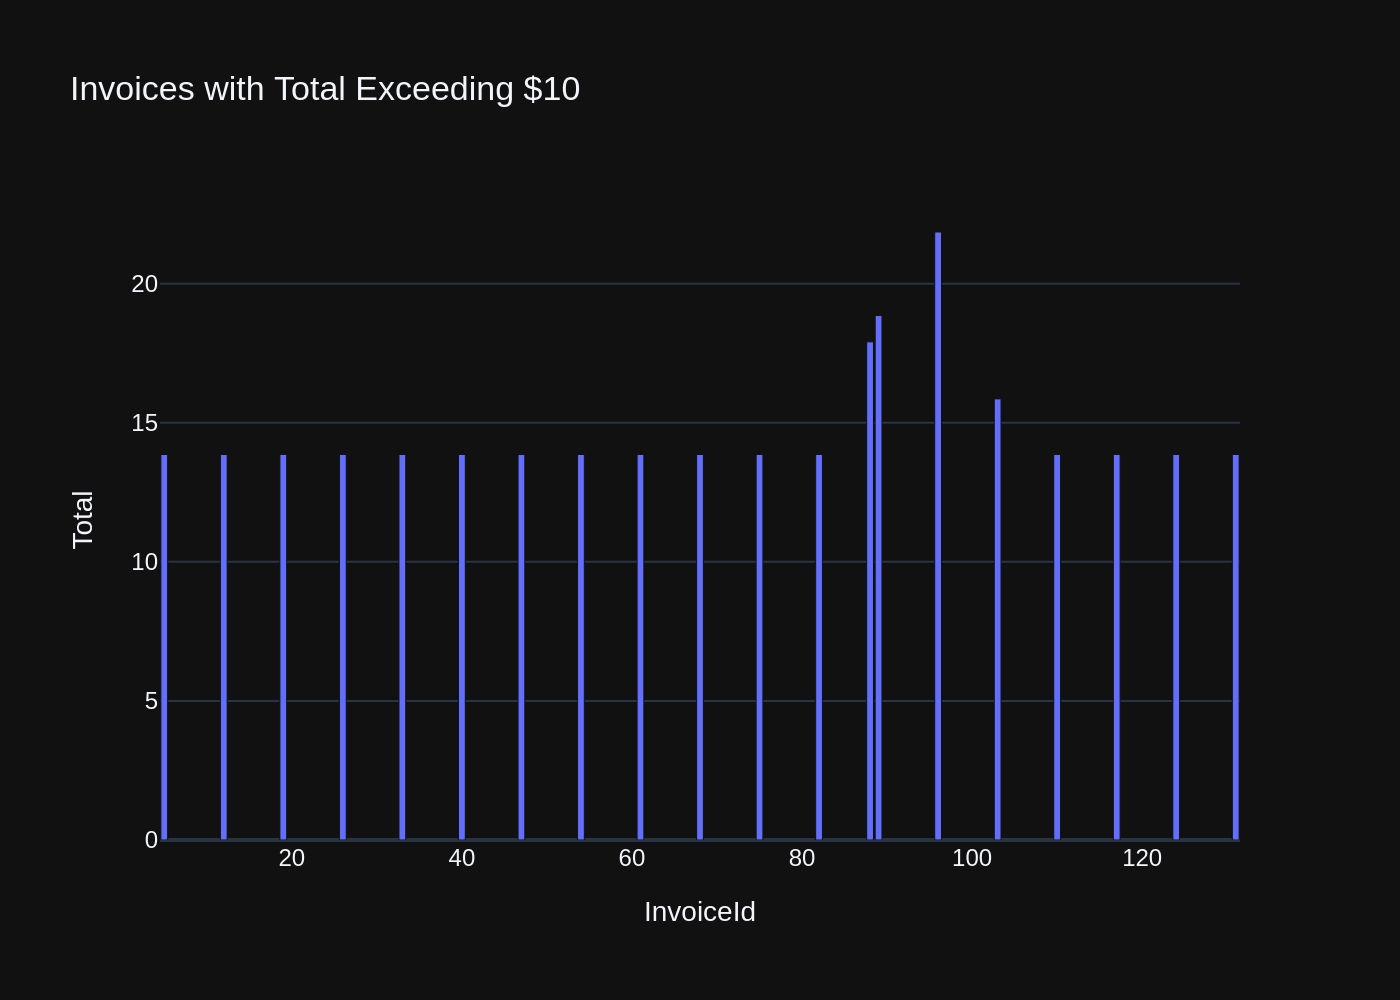





# QUESTION  - 11:  Find all invoices since 2010 and the total amount invoiced:


Using model gpt-4o-mini for 1551.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * FROM invoices WHERE InvoiceDate >= '2010-01-01' LIMIT 20


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,84,43,2010-01-08 00:00:00,"68, Rue Jouvence",Dijon,None,France,21000,1.98
1,85,45,2010-01-08 00:00:00,Erzsébet krt. 58.,Budapest,None,Hungary,H-1073,1.98
2,86,47,2010-01-09 00:00:00,"Via Degli Scipioni, 43",Rome,RM,Italy,00192,3.96
3,87,51,2010-01-10 00:00:00,Celsiusg. 9,Stockholm,None,Sweden,11230,6.94
4,88,57,2010-01-13 00:00:00,"Calle Lira, 198",Santiago,None,Chile,None,17.91
5,89,7,2010-01-18 00:00:00,"Rotenturmstraße 4, 1010 Innere Stadt",Vienne,None,Austria,1010,18.86
6,90,21,2010-01-26 00:00:00,801 W 4th Street,Reno,NV,USA,89503,0.99
7,91,22,2010-02-08 00:00:00,120 S Orange Ave,Orlando,FL,USA,32801,1.98
8,92,24,2010-02-08 00:00:00,162 E Superior Street,Chicago,IL,USA,60611,1.98
9,93,26,2010-02-09 00:00:00,2211 W Berry Street,Fort Worth,TX,USA,76110,3.96


Using model gpt-4o-mini for 236.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['Total'].iloc[0],
        title={"text": "Total Amount Invoiced"},
        delta={'reference': 0}
    ))
else:
    fig = px.bar(df, x='InvoiceDate', y='Total', title='Total Amount Invoiced Since 2010')

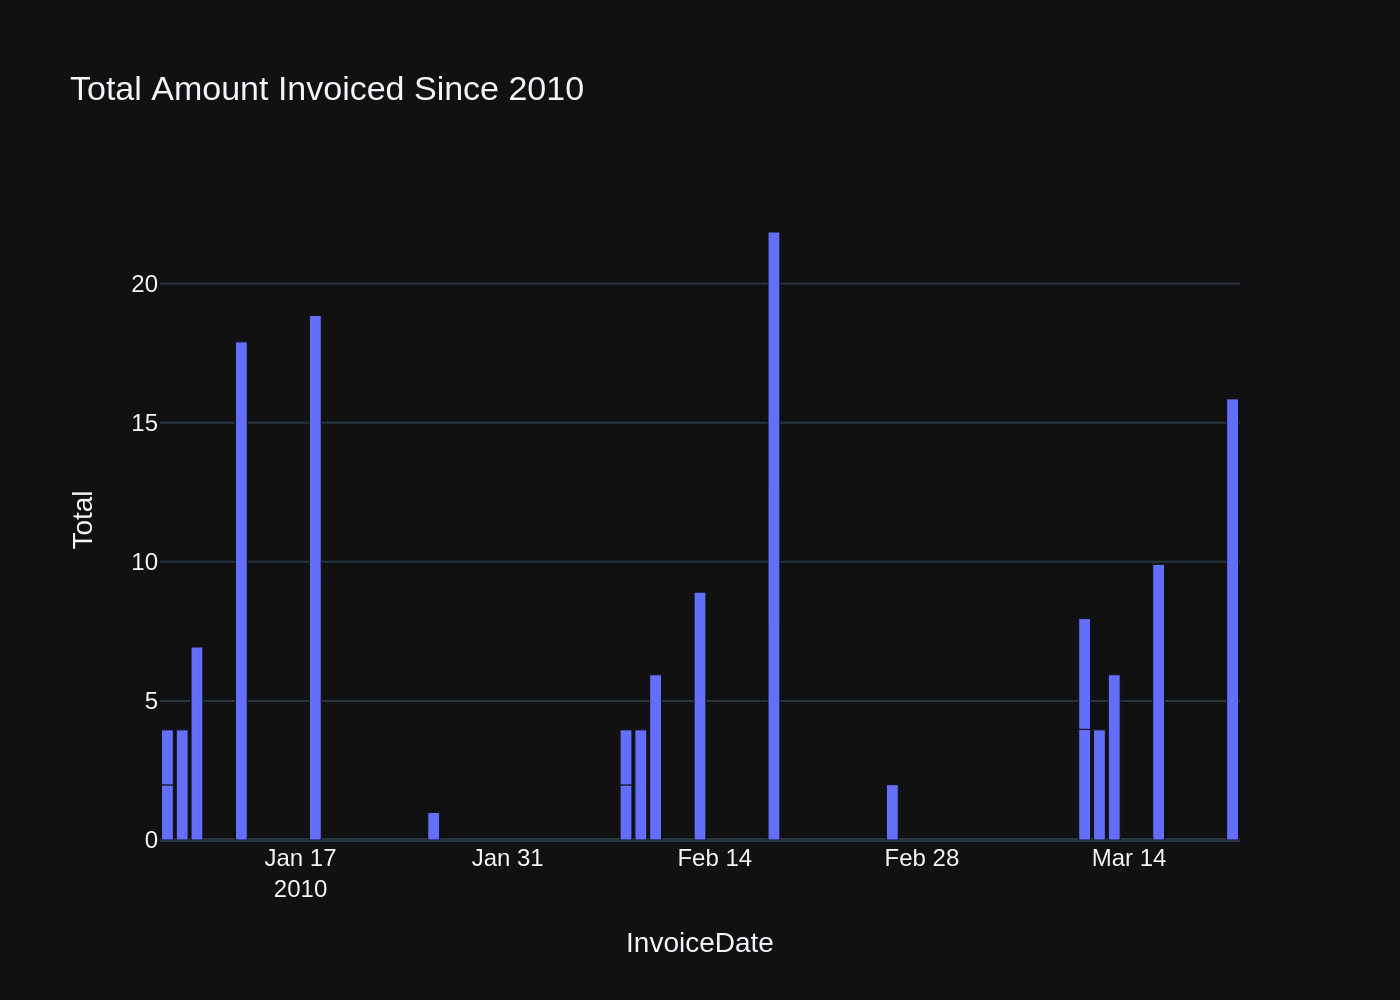





# QUESTION  - 12:  List all employees and their reporting manager's name (if any):


Using model gpt-4o-mini for 1508.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT e.FirstName || ' ' || e.LastName AS EmployeeName, 
       m.FirstName || ' ' || m.LastName AS ManagerName 
FROM employees e 
LEFT JOIN employees m ON e.ReportsTo = m.EmployeeId;


[( <SQL> )]
generated SQL statement



SELECT e.FirstName || ' ' || e.LastName AS EmployeeName, 
       m.FirstName || ' ' || m.LastName AS ManagerName 
FROM employees e 
LEFT JOIN employees m ON e.ReportsTo = m.EmployeeId;


[( <DataFrame> )]
queried dataframe



,EmployeeName,ManagerName
0,Andrew Adams,None
1,Nancy Edwards,Andrew Adams
2,Jane Peacock,Nancy Edwards
3,Margaret Park,Nancy Edwards
4,Steve Johnson,Nancy Edwards
5,Michael Mitchell,Andrew Adams
6,Robert King,Michael Mitchell
7,Laura Callahan,Michael Mitchell


Using model gpt-4o-mini for 215.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=1,
        title={"text": f"Employee: {df['EmployeeName'].iloc[0]}<br>Manager: {df['ManagerName'].iloc[0]}"},
    ))
else:
    fig = px.bar(df, x='EmployeeName', y='ManagerName', title='Employees and Their Managers')

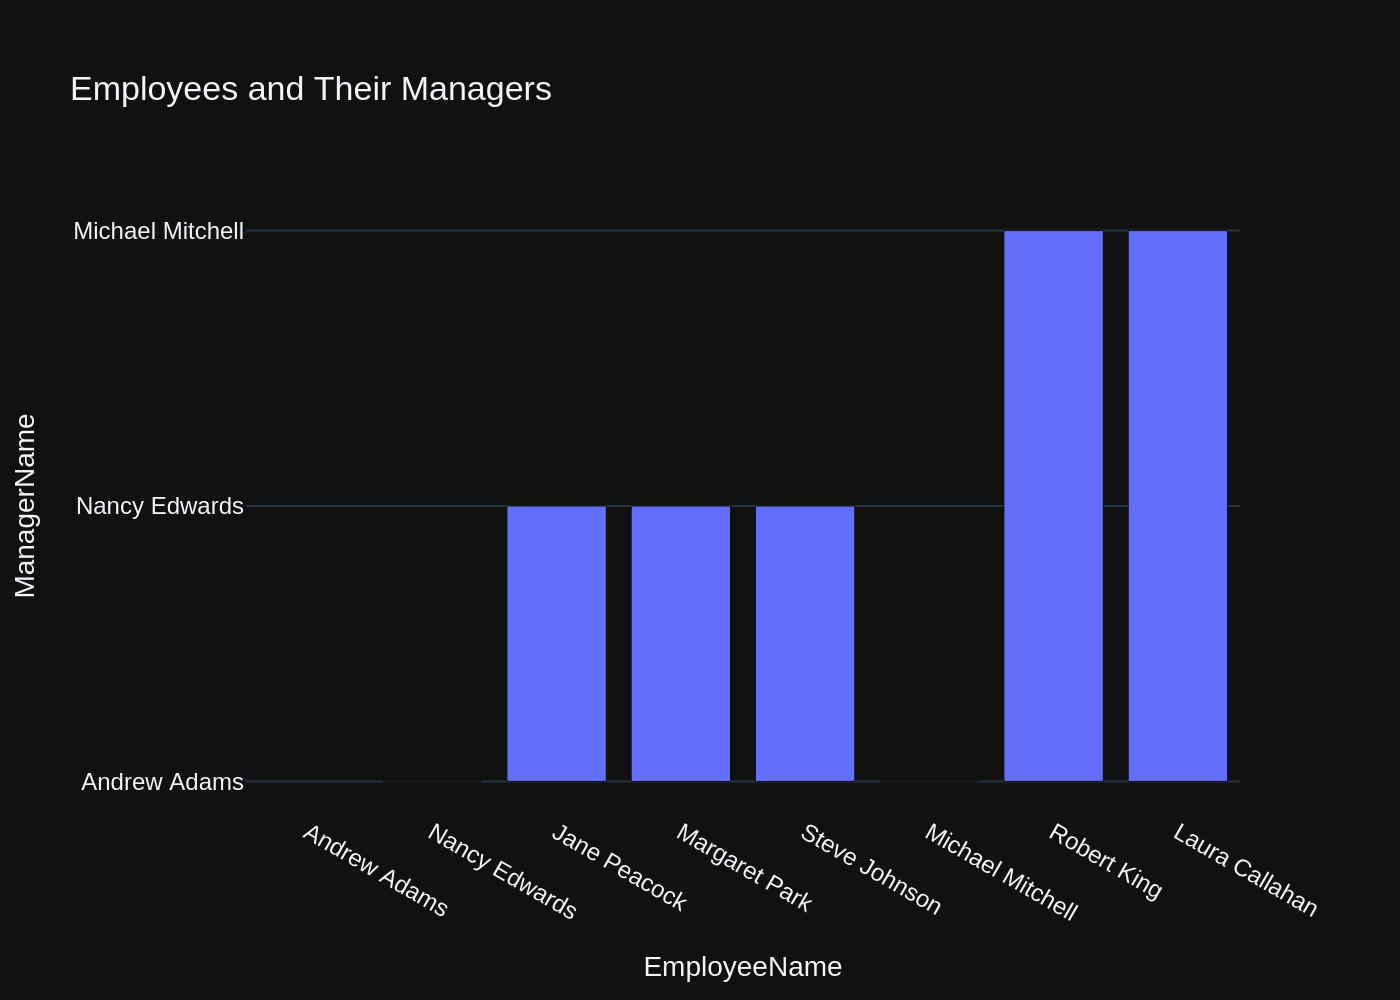





# QUESTION  - 13:   Get the average invoice total for each customer:


Using model gpt-4o-mini for 1336.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT CustomerId, AVG(Total) AS AverageInvoiceTotal 
FROM invoices 
GROUP BY CustomerId LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,AverageInvoiceTotal
0,1,5.660000
1,2,5.374286
2,3,5.660000
3,4,5.660000
4,5,5.802857
5,6,7.088571
6,7,6.088571
7,8,5.374286
8,9,5.374286
9,10,5.374286


Using model gpt-4o-mini for 192.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['AverageInvoiceTotal'].iloc[0],
        title={"text": f"Average Invoice Total for Customer {df['CustomerId'].iloc[0]}"}
    ))
else:
    fig = px.bar(df, x='CustomerId', y='AverageInvoiceTotal', 
                 title='Average Invoice Total for Each Customer', 
                 labels={'CustomerId': 'Customer ID', 'AverageInvoiceTotal': 'Average Invoice Total'})

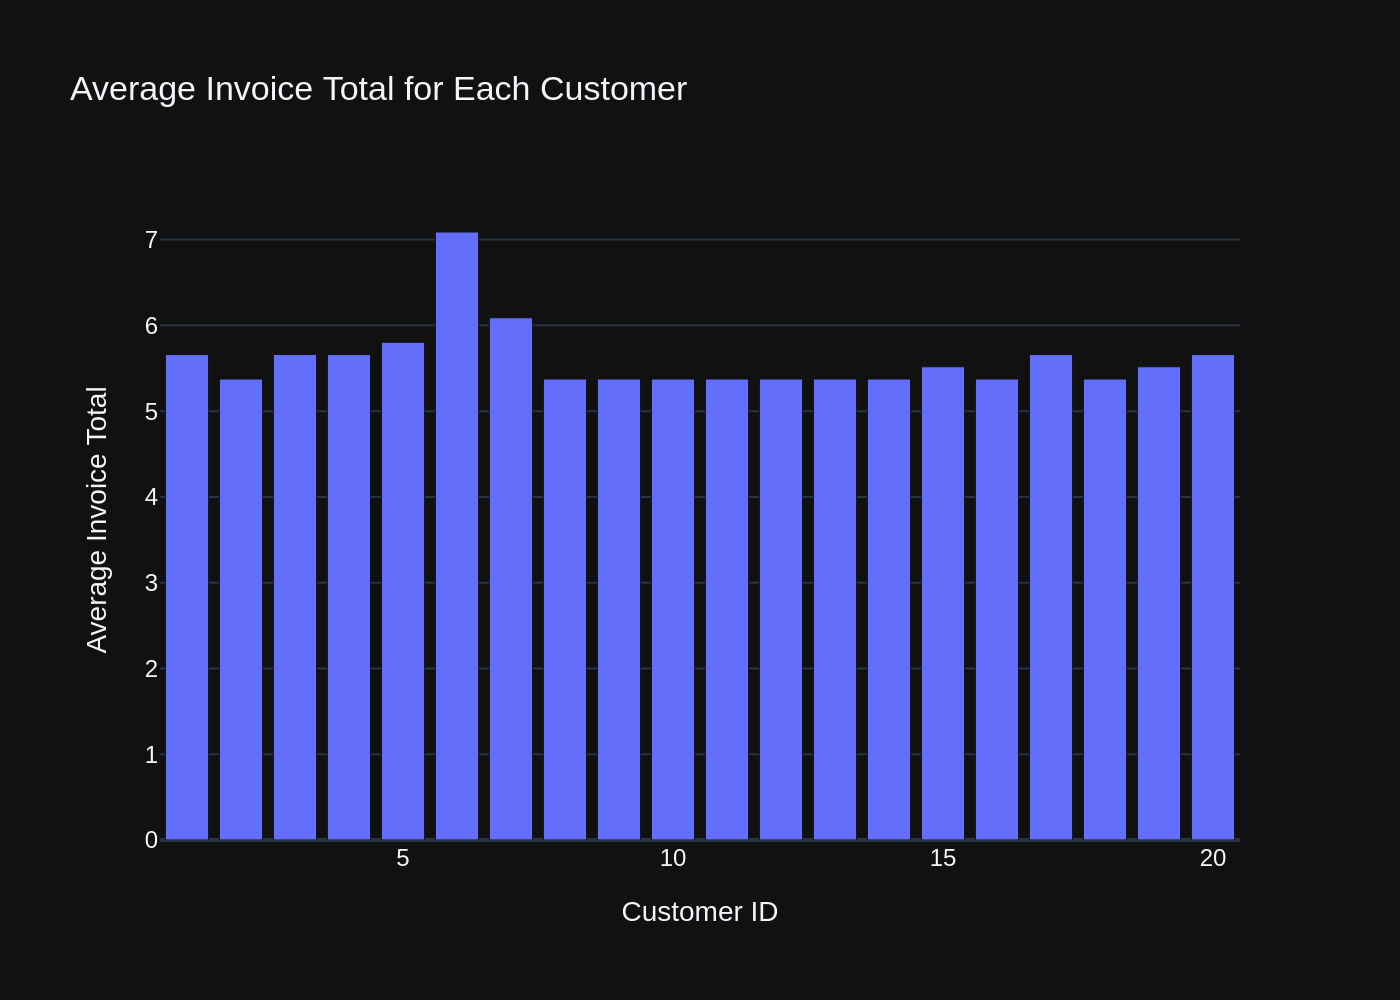





# QUESTION  - 14:  Find the top 5 most expensive tracks (based on unit price):


Using model gpt-4o-mini for 1137.25 tokens (approx)

[( EXTRACTED SQL )]
SELECT * FROM tracks ORDER BY UnitPrice DESC LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT * FROM tracks ORDER BY UnitPrice DESC LIMIT 5;


[( <DataFrame> )]
queried dataframe



,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,2819,Battlestar Galactica: The Story So Far,226,3,18,None,2622250,490750393,1.99
1,2820,Occupation / Precipice,227,3,19,None,5286953,1054423946,1.99
2,2821,"Exodus, Pt. 1",227,3,19,None,2621708,475079441,1.99
3,2822,"Exodus, Pt. 2",227,3,19,None,2618000,466820021,1.99
4,2823,Collaborators,227,3,19,None,2626626,483484911,1.99


Using model gpt-4o-mini for 222.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['UnitPrice'].iloc[0],
        title={"text": f"Most Expensive Track: {df['Name'].iloc[0]}"},
        number={'prefix': "$"}
    ))
else:
    fig = px.bar(df, x='Name', y='UnitPrice', title='Top 5 Most Expensive Tracks',
                 labels={'UnitPrice': 'Unit Price ($)', 'Name': 'Track Name'})

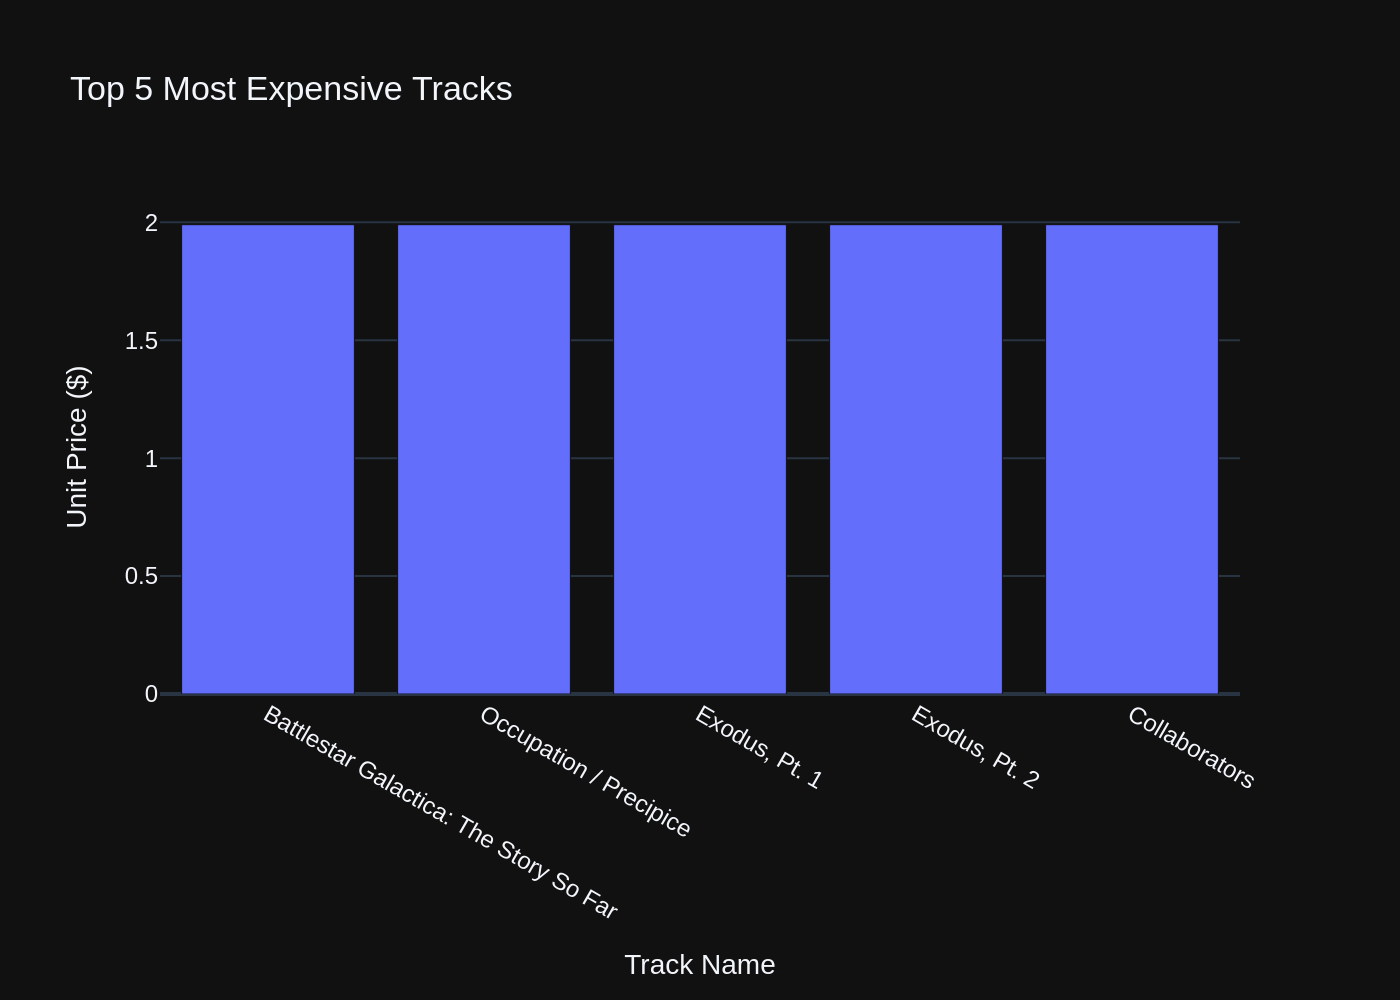





# QUESTION  - 15:  List all genres and the number of tracks in each genre:


Using model gpt-4o-mini for 1056.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT genres.Name AS GenreName, COUNT(tracks.TrackId) AS TrackCount 
FROM genres 
LEFT JOIN tracks ON genres.GenreId = tracks.GenreId 
GROUP BY genres.GenreId LIMIT 20


[( <DataFrame> )]
queried dataframe



,GenreName,TrackCount
0,Rock,1297
1,Jazz,130
2,Metal,374
3,Alternative & Punk,332
4,Rock And Roll,12
5,Blues,81
6,Latin,579
7,Reggae,58
8,Pop,48
9,Soundtrack,43


Using model gpt-4o-mini for 206.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['TrackCount'].iloc[0],
        title={"text": f"Genre: {df['GenreName'].iloc[0]}<br>Track Count"},
    ))
else:
    fig = px.bar(df, x='GenreName', y='TrackCount', title='Number of Tracks by Genre')

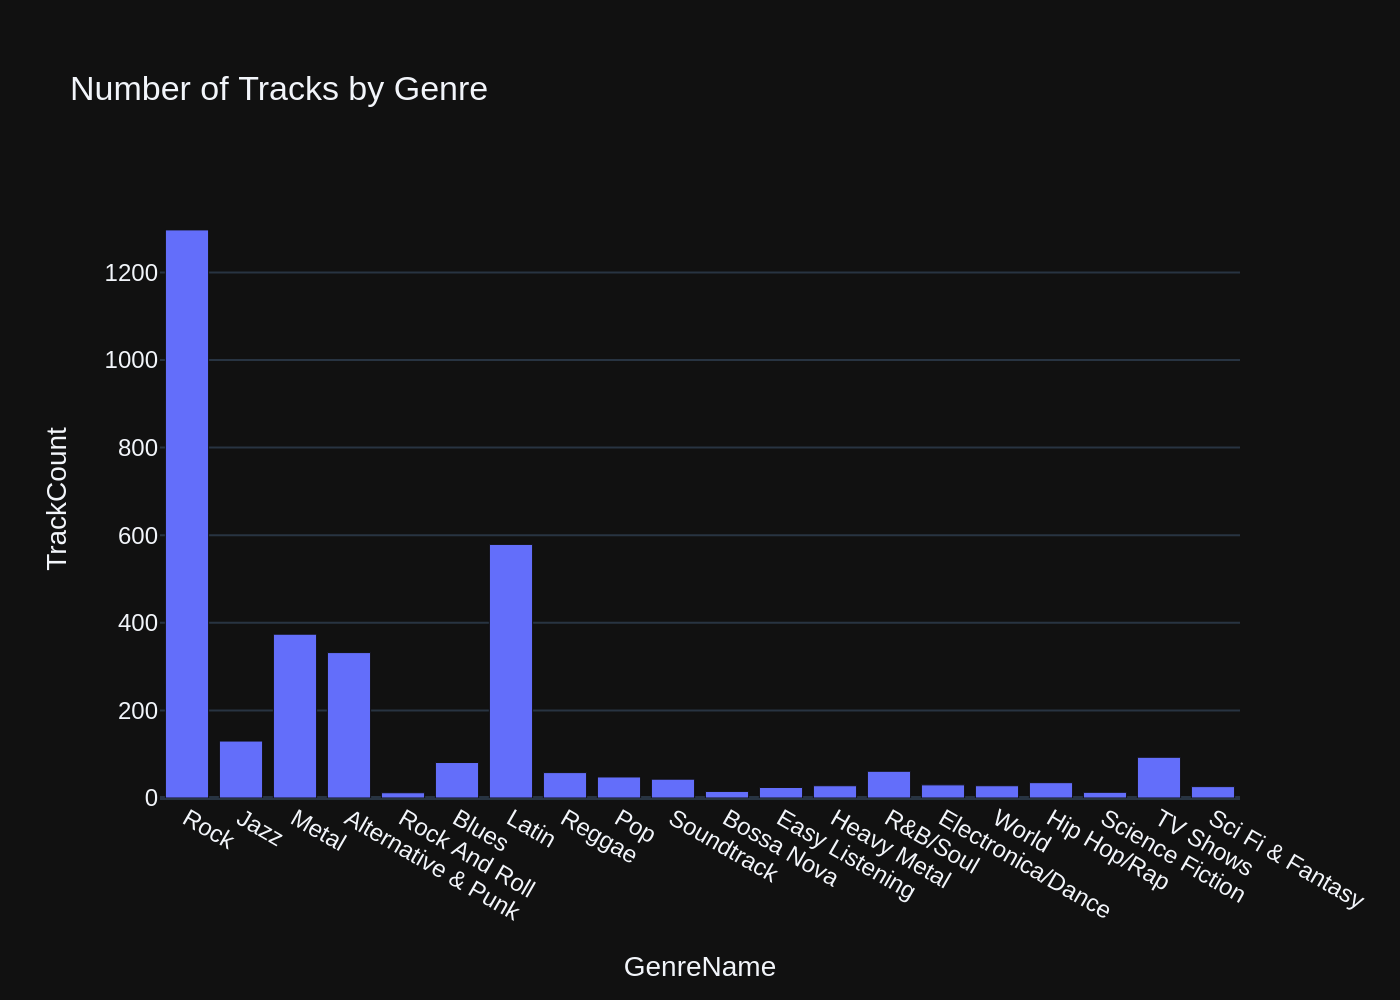





# QUESTION  - 16:  Get all genres that do not have any tracks associated with them:


Using model gpt-4o-mini for 1122.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT genres.Name AS GenreName 
FROM genres 
LEFT JOIN tracks ON genres.GenreId = tracks.GenreId 
WHERE tracks.TrackId IS NULL LIMIT 20


[( <DataFrame> )]
queried dataframe



,GenreName



[( RETRY )]
***** 1 *****

Using model gpt-4o-mini for 1298.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT genres.Name AS GenreName 
FROM genres 
LEFT JOIN tracks ON genres.GenreId = tracks.GenreId 
WHERE tracks.TrackId IS NULL LIMIT 20


[( <DataFrame> )]
queried dataframe



,GenreName



[( RETRY )]
***** 2 *****

Using model gpt-4o-mini for 1345.5 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT genres.Name AS GenreName 
FROM genres 
LEFT JOIN tracks ON genres.GenreId = tracks.GenreId 
WHERE tracks.TrackId IS NULL LIMIT 20


[( <DataFrame> )]
queried dataframe



,GenreName



[( RETRY )]
***** 3 *****

Using model gpt-4o-mini for 1405.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT genres.Name AS GenreName 
FROM genres 
LEFT JOIN tracks ON genres.GenreId = tracks.GenreId 
WHERE tracks.TrackId IS NULL LIMIT 20


[( <DataFrame> )]
queried dataframe



,GenreName






# QUESTION  - 17:  List all customers who have not placed any orders:


Using model gpt-4o-mini for 1631.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * FROM customers 
WHERE CustomerId NOT IN (SELECT DISTINCT CustomerId FROM invoices) LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId



[( RETRY )]
***** 1 *****

Using model gpt-4o-mini for 1520.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * FROM customers 
WHERE CustomerId NOT IN (SELECT DISTINCT CustomerId FROM invoices) LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId



[( RETRY )]
***** 2 *****

Using model gpt-4o-mini for 1533.0 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * FROM customers 
WHERE CustomerId NOT IN (SELECT DISTINCT CustomerId FROM invoices) LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId



[( RETRY )]
***** 3 *****

Using model gpt-4o-mini for 1592.75 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT * FROM customers 
WHERE CustomerId NOT IN (SELECT DISTINCT CustomerId FROM invoices) LIMIT 20


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId






# QUESTION  - 18:   
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    


Using model gpt-4o-mini for 1142.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT artists.Name AS ArtistName, COUNT(tracks.TrackId) AS TrackCount 
FROM artists 
JOIN albums ON artists.ArtistId = albums.ArtistId 
JOIN tracks ON albums.AlbumId = tracks.AlbumId 
GROUP BY artists.ArtistId 
ORDER BY TrackCount DESC 
LIMIT 10;


[( <SQL> )]
generated SQL statement



SELECT artists.Name AS ArtistName, COUNT(tracks.TrackId) AS TrackCount 
FROM artists 
JOIN albums ON artists.ArtistId = albums.ArtistId 
JOIN tracks ON albums.AlbumId = tracks.AlbumId 
GROUP BY artists.ArtistId 
ORDER BY TrackCount DESC 
LIMIT 10;


[( <DataFrame> )]
queried dataframe



,ArtistName,TrackCount
0,Iron Maiden,213
1,U2,135
2,Led Zeppelin,114
3,Metallica,112
4,Deep Purple,92
5,Lost,92
6,Pearl Jam,67
7,Lenny Kravitz,57
8,Various Artists,56
9,The Office,53


Using model gpt-4o-mini for 275.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+gauge+delta",
        value=df['TrackCount'].iloc[0],
        title={'text': f"Top Artist: {df['ArtistName'].iloc[0]}"},
        delta={'reference': 0}
    ))
else:
    fig = px.bar(df, x='ArtistName', y='TrackCount', title='Top 10 Most Popular Artists by Track Count',
                 labels={'TrackCount': 'Number of Tracks', 'ArtistName': 'Artist Name'})

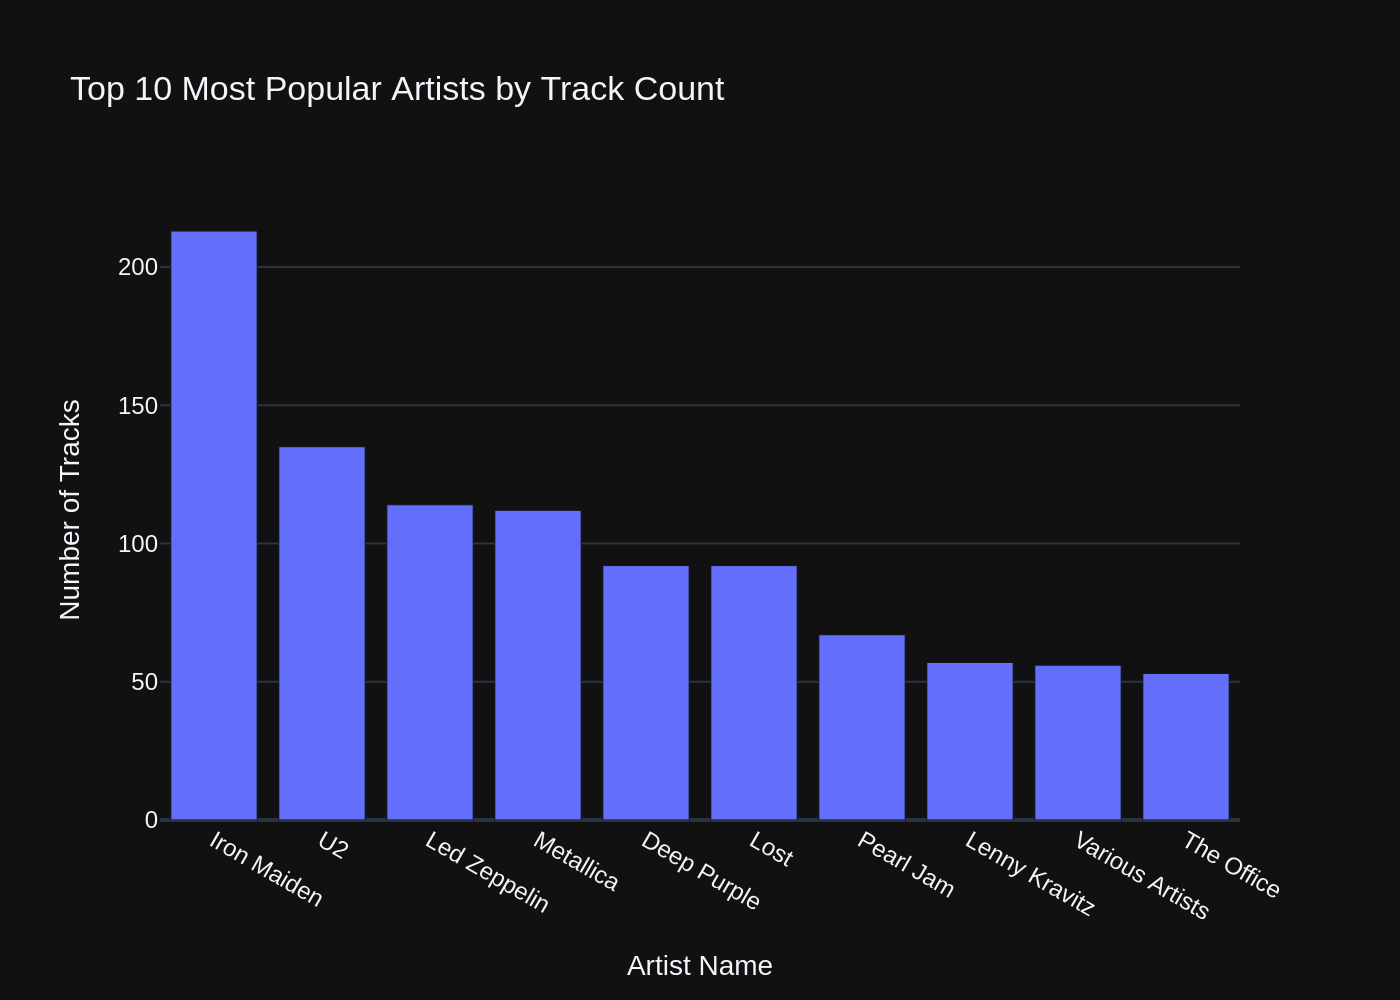





# QUESTION  - 19:  List all customers from Canada and their email addresses:


Using model gpt-4o-mini for 1449.25 tokens (approx)

[( <SQL> )]
generated SQL statement



SELECT FirstName, LastName, Email 
FROM customers 
WHERE Country = 'Canada' LIMIT 20


[( <DataFrame> )]
queried dataframe



,FirstName,LastName,Email
0,François,Tremblay,ftremblay@gmail.com
1,Mark,Philips,mphilips12@shaw.ca
2,Jennifer,Peterson,jenniferp@rogers.ca
3,Robert,Brown,robbrown@shaw.ca
4,Edward,Francis,edfrancis@yachoo.ca
5,Martha,Silk,marthasilk@gmail.com
6,Aaron,Mitchell,aaronmitchell@yahoo.ca
7,Ellie,Sullivan,ellie.sullivan@shaw.ca


Using model gpt-4o-mini for 190.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=1,
        title={"text": f"Customer: {df['FirstName'].values[0]} {df['LastName'].values[0]}"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = px.bar(df, x='FirstName', y='LastName', title='Customers from Canada', text='Email')

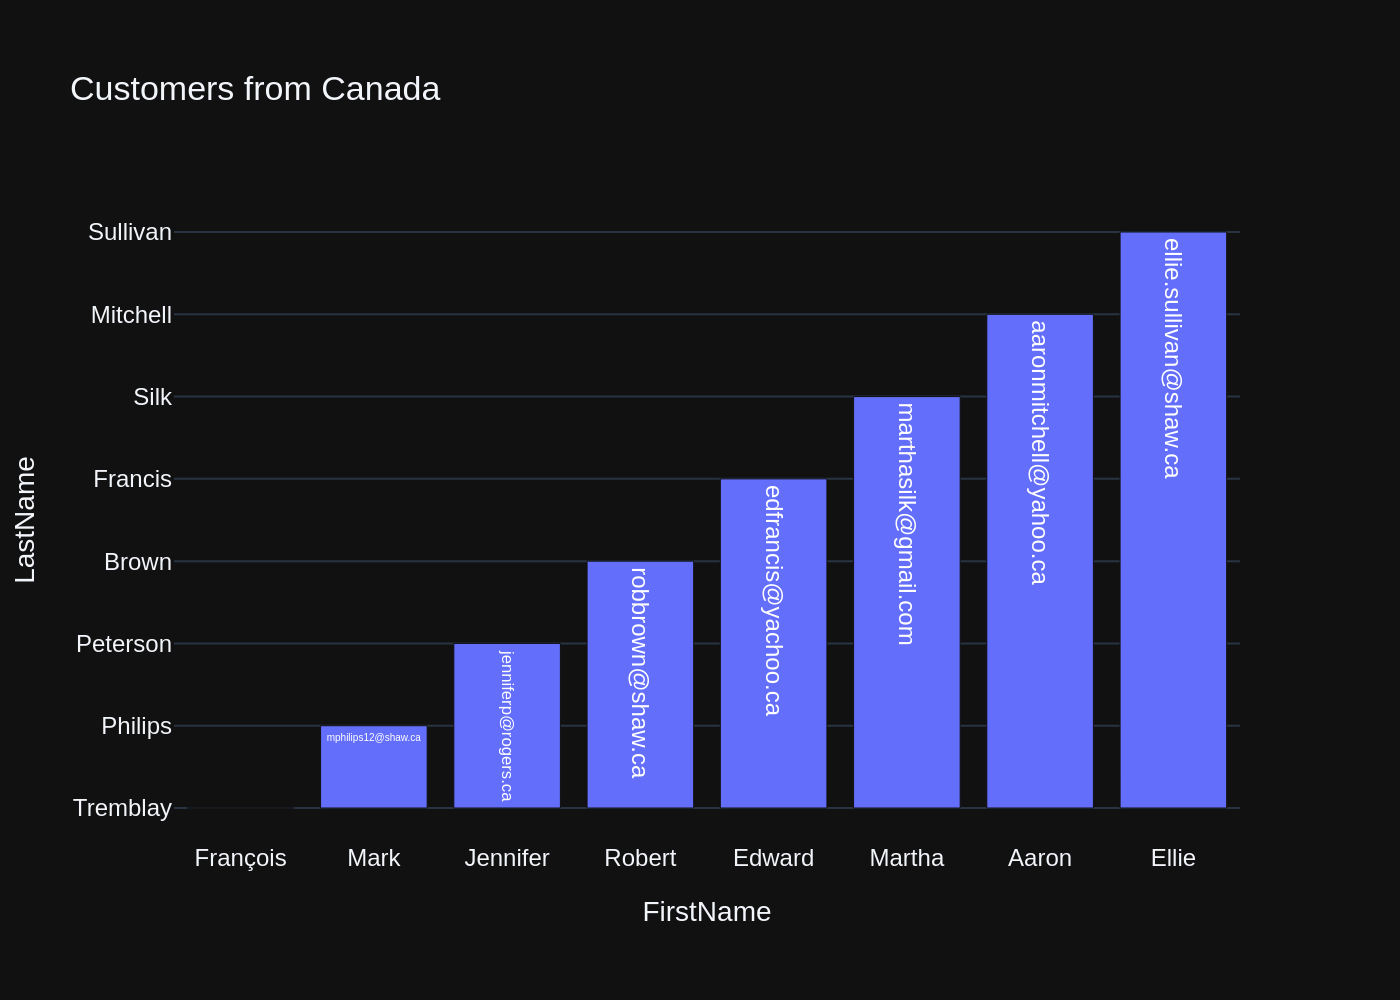





# QUESTION  - 20:  Find the customer with the most invoices 


Using model gpt-4o-mini for 1440.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT CustomerId, COUNT(*) AS InvoiceCount 
FROM invoices 
GROUP BY CustomerId 
ORDER BY InvoiceCount DESC 
LIMIT 1;


[( <SQL> )]
generated SQL statement



SELECT CustomerId, COUNT(*) AS InvoiceCount 
FROM invoices 
GROUP BY CustomerId 
ORDER BY InvoiceCount DESC 
LIMIT 1;


[( <DataFrame> )]
queried dataframe



,CustomerId,InvoiceCount
0,1,7


Using model gpt-4o-mini for 190.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['InvoiceCount'].iloc[0],
        title={"text": "Customer with Most Invoices"},
        delta={'reference': 0}
    ))
else:
    fig = go.Figure(data=[go.Bar(
        x=df['CustomerId'],
        y=df['InvoiceCount']
    )])

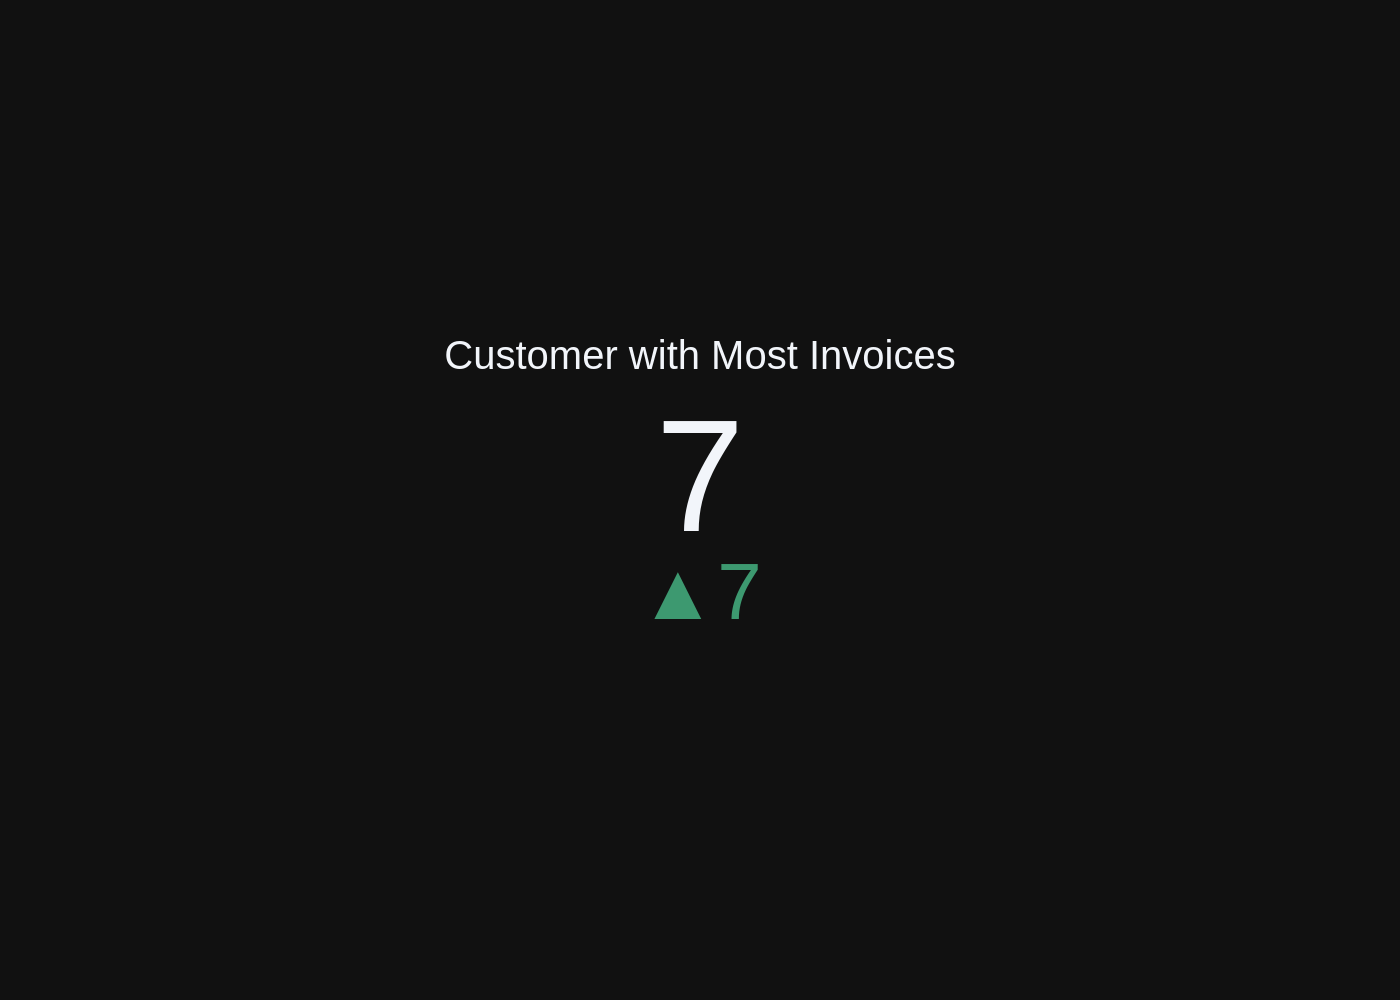





# QUESTION  - 21:  Find the customer who bought the most albums in total quantity (across all invoices):


Using model gpt-4o-mini for 1302.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT invoices.CustomerId, SUM(invoice_items.Quantity) AS TotalAlbums 
FROM invoices 
JOIN invoice_items ON invoices.InvoiceId = invoice_items.InvoiceId 
JOIN tracks ON invoice_items.TrackId = tracks.TrackId 
WHERE tracks.AlbumId IS NOT NULL 
GROUP BY invoices.CustomerId 
ORDER BY TotalAlbums DESC 
LIMIT 1;


[( <SQL> )]
generated SQL statement



SELECT invoices.CustomerId, SUM(invoice_items.Quantity) AS TotalAlbums 
FROM invoices 
JOIN invoice_items ON invoices.InvoiceId = invoice_items.InvoiceId 
JOIN tracks ON invoice_items.TrackId = tracks.TrackId 
WHERE tracks.AlbumId IS NOT NULL 
GROUP BY invoices.CustomerId 
ORDER BY TotalAlbums DESC 
LIMIT 1;


[( <DataFrame> )]
queried dataframe



,CustomerId,TotalAlbums
0,1,38


Using model gpt-4o-mini for 249.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['TotalAlbums'].iloc[0],
        title={"text": f"Customer ID: {df['CustomerId'].iloc[0]}<br>Total Albums Bought"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = go.Figure(data=[go.Bar(
        x=df['CustomerId'],
        y=df['TotalAlbums']
    )])

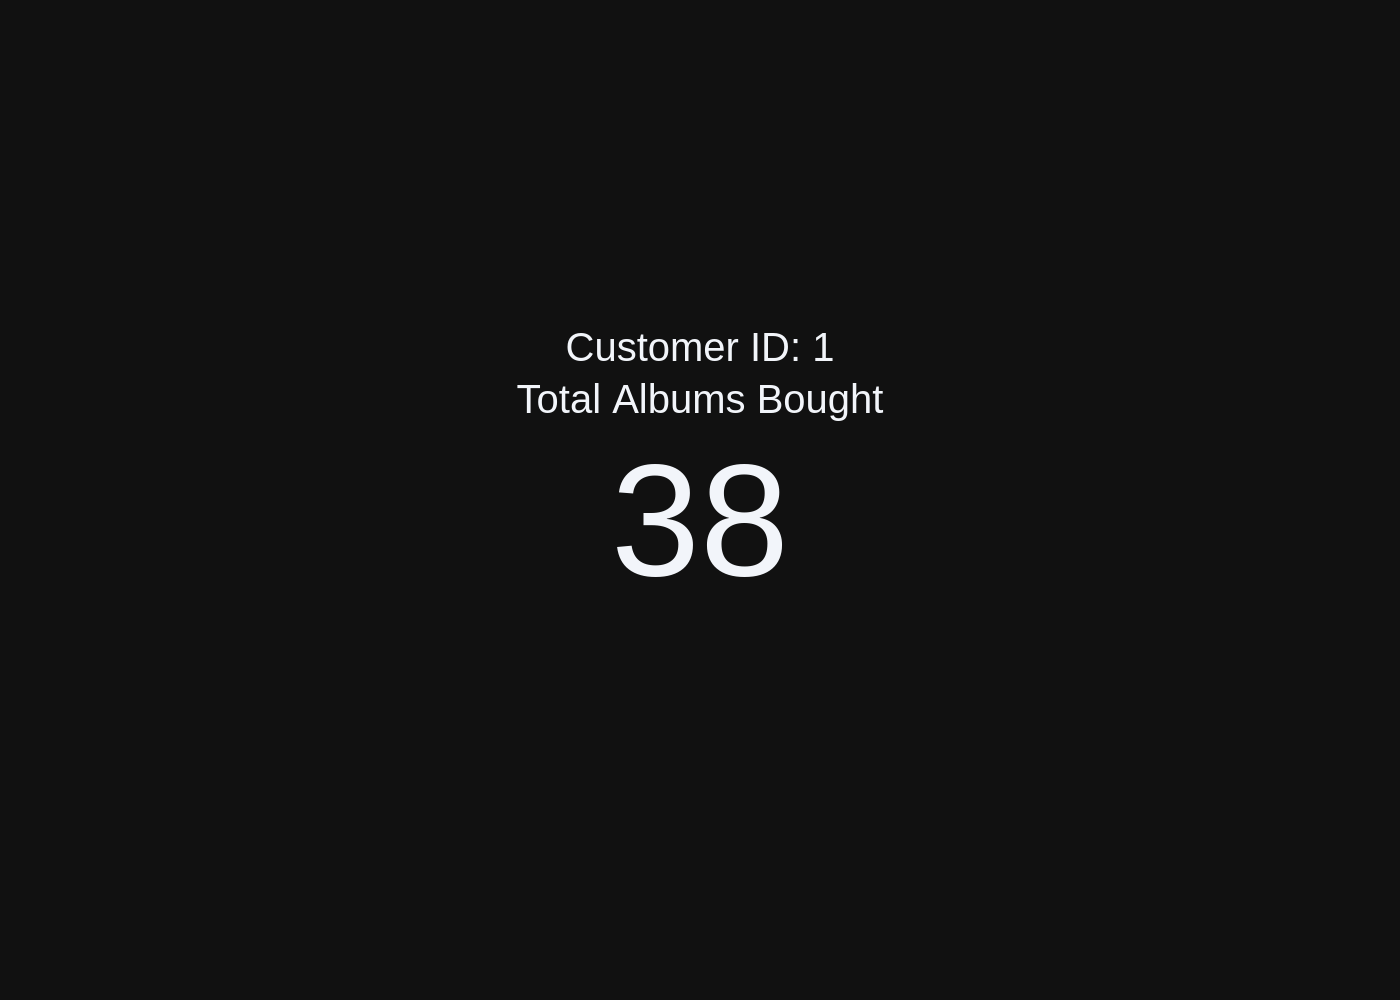





# QUESTION  - 22:        
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    


Using model gpt-4o-mini for 1363.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT invoices.CustomerId, SUM(invoice_items.Quantity) AS TotalAlbums 
FROM invoices 
JOIN invoice_items ON invoices.InvoiceId = invoice_items.InvoiceId 
JOIN tracks ON invoice_items.TrackId = tracks.TrackId 
WHERE tracks.AlbumId IS NOT NULL 
GROUP BY invoices.CustomerId 
ORDER BY TotalAlbums DESC 
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT invoices.CustomerId, SUM(invoice_items.Quantity) AS TotalAlbums 
FROM invoices 
JOIN invoice_items ON invoices.InvoiceId = invoice_items.InvoiceId 
JOIN tracks ON invoice_items.TrackId = tracks.TrackId 
WHERE tracks.AlbumId IS NOT NULL 
GROUP BY invoices.CustomerId 
ORDER BY TotalAlbums DESC 
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,CustomerId,TotalAlbums
0,1,38
1,2,38
2,3,38
3,4,38
4,5,38


Using model gpt-4o-mini for 270.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['TotalAlbums'].iloc[0],
        title={"text": f"Customer ID: {df['CustomerId'].iloc[0]}"},
        delta={'reference': 0}
    ))
else:
    fig = px.bar(df, x='CustomerId', y='TotalAlbums', 
                 title='Top 5 Customers by Total Albums Purchased',
                 labels={'CustomerId': 'Customer ID', 'TotalAlbums': 'Total Albums'},
                 color='TotalAlbums')

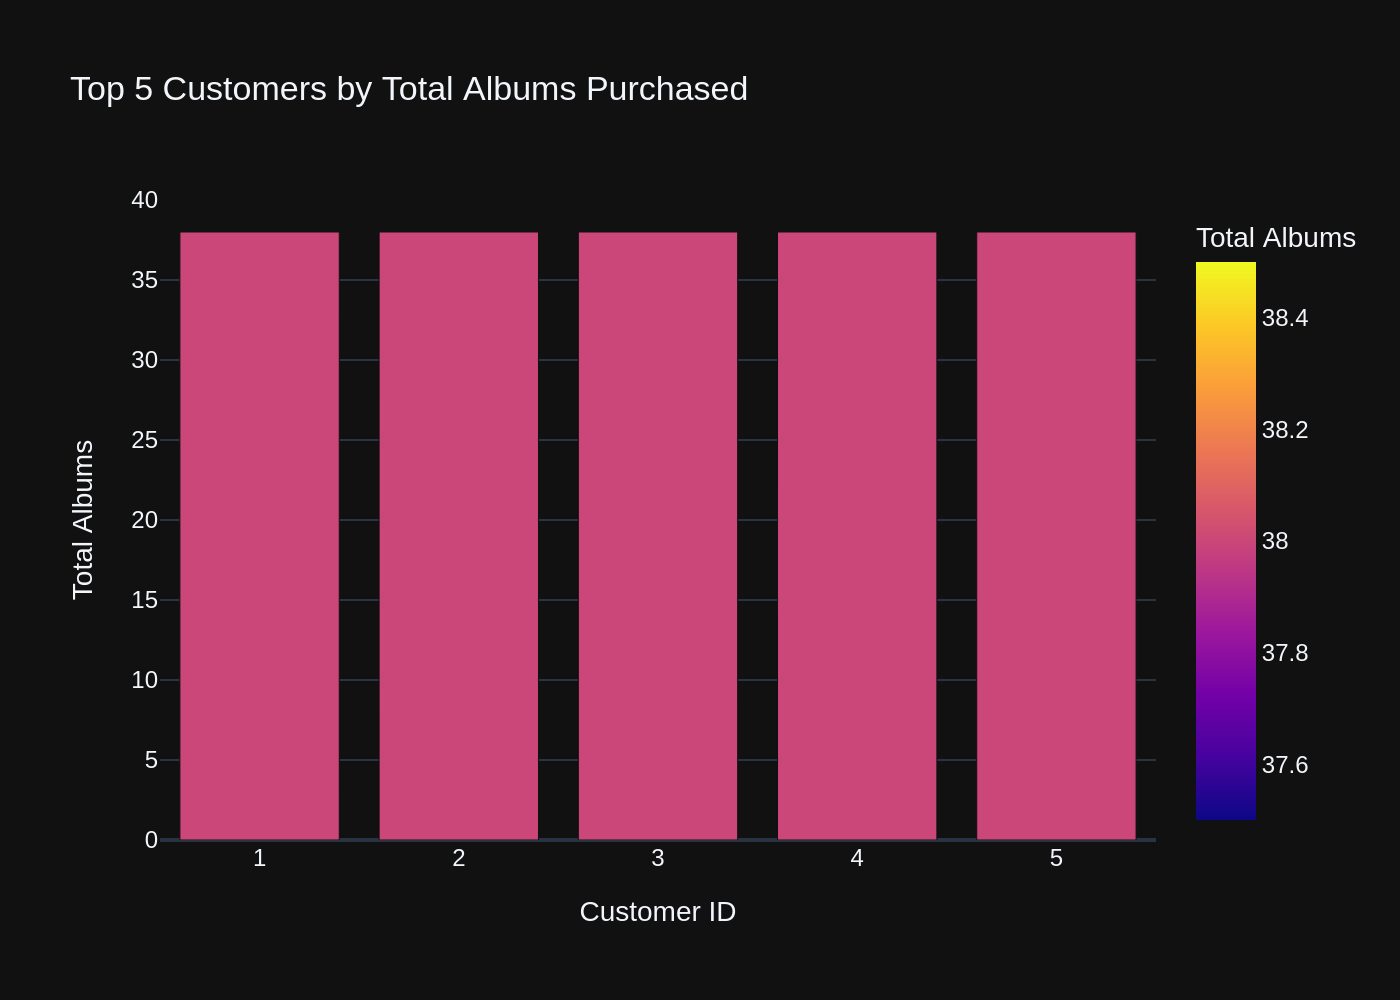





# QUESTION  - 23:    
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    


Using model gpt-4o-mini for 1734.75 tokens (approx)

[( EXTRACTED SQL )]
SELECT CustomerId, SUM(Total) AS TotalSpent 
FROM invoices 
GROUP BY CustomerId 
ORDER BY TotalSpent DESC 
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT CustomerId, SUM(Total) AS TotalSpent 
FROM invoices 
GROUP BY CustomerId 
ORDER BY TotalSpent DESC 
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,CustomerId,TotalSpent
0,6,49.62
1,26,47.62
2,57,46.62
3,45,45.62
4,46,45.62


Using model gpt-4o-mini for 229.0 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+delta",
        value=df['TotalSpent'].iloc[0],
        title={"text": f"Customer ID: {df['CustomerId'].iloc[0]}"},
        delta={'reference': 0}
    ))
else:
    fig = px.bar(df, x='CustomerId', y='TotalSpent', 
                 title='Top 5 Customers by Total Spent',
                 labels={'CustomerId': 'Customer ID', 'TotalSpent': 'Total Spent'},
                 color='TotalSpent')

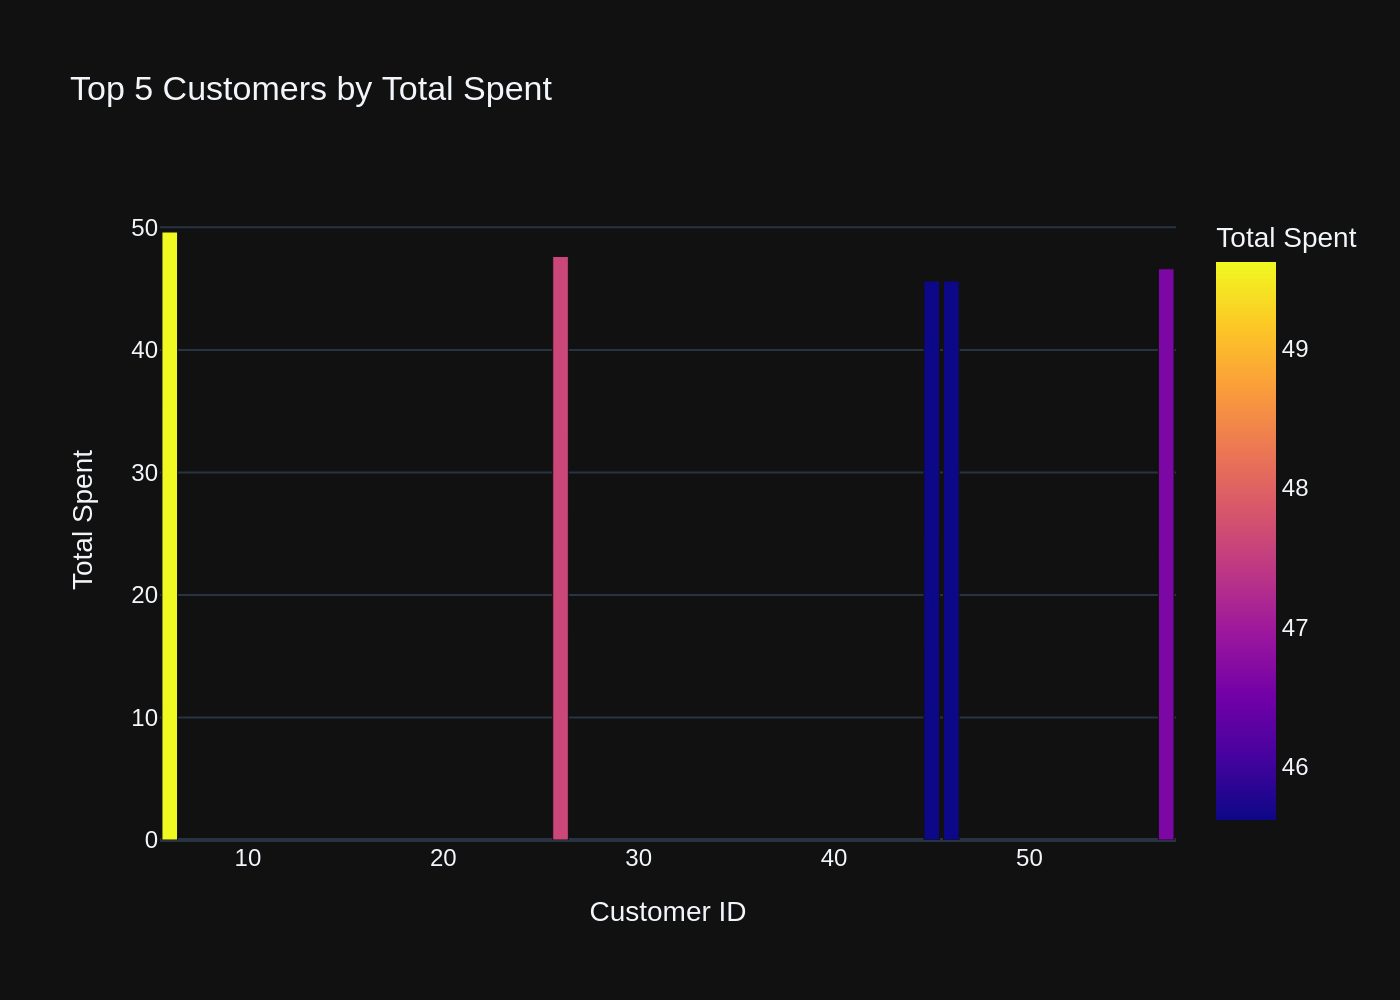





# QUESTION  - 24:  Get all playlists containing at least 10 tracks and the total duration of those tracks:


Using model gpt-4o-mini for 1326.25 tokens (approx)

[( EXTRACTED SQL )]
SELECT playlist_track.PlaylistId, SUM(tracks.Milliseconds) AS TotalDuration 
FROM playlist_track 
JOIN tracks ON playlist_track.TrackId = tracks.TrackId 
GROUP BY playlist_track.PlaylistId 
HAVING COUNT(playlist_track.TrackId) >= 10;


[( <SQL> )]
generated SQL statement



SELECT playlist_track.PlaylistId, SUM(tracks.Milliseconds) AS TotalDuration 
FROM playlist_track 
JOIN tracks ON playlist_track.TrackId = tracks.TrackId 
GROUP BY playlist_track.PlaylistId 
HAVING COUNT(playlist_track.TrackId) >= 10;


[( <DataFrame> )]
queried dataframe



,PlaylistId,TotalDuration
0,1,877683083
1,3,501094957
2,5,398705153
3,8,877683083
4,10,501094957
5,11,9486559
6,12,21770592
7,13,6755730
8,14,7575051
9,15,7439811


Using model gpt-4o-mini for 233.5 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number+gauge+delta",
        value=df['TotalDuration'].iloc[0],
        title={"text": f"Total Duration for Playlist ID {df['PlaylistId'].iloc[0]}"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = px.bar(df, x='PlaylistId', y='TotalDuration', 
                 title='Total Duration of Playlists with at least 10 Tracks',
                 labels={'PlaylistId': 'Playlist ID', 'TotalDuration': 'Total Duration (Milliseconds)'})

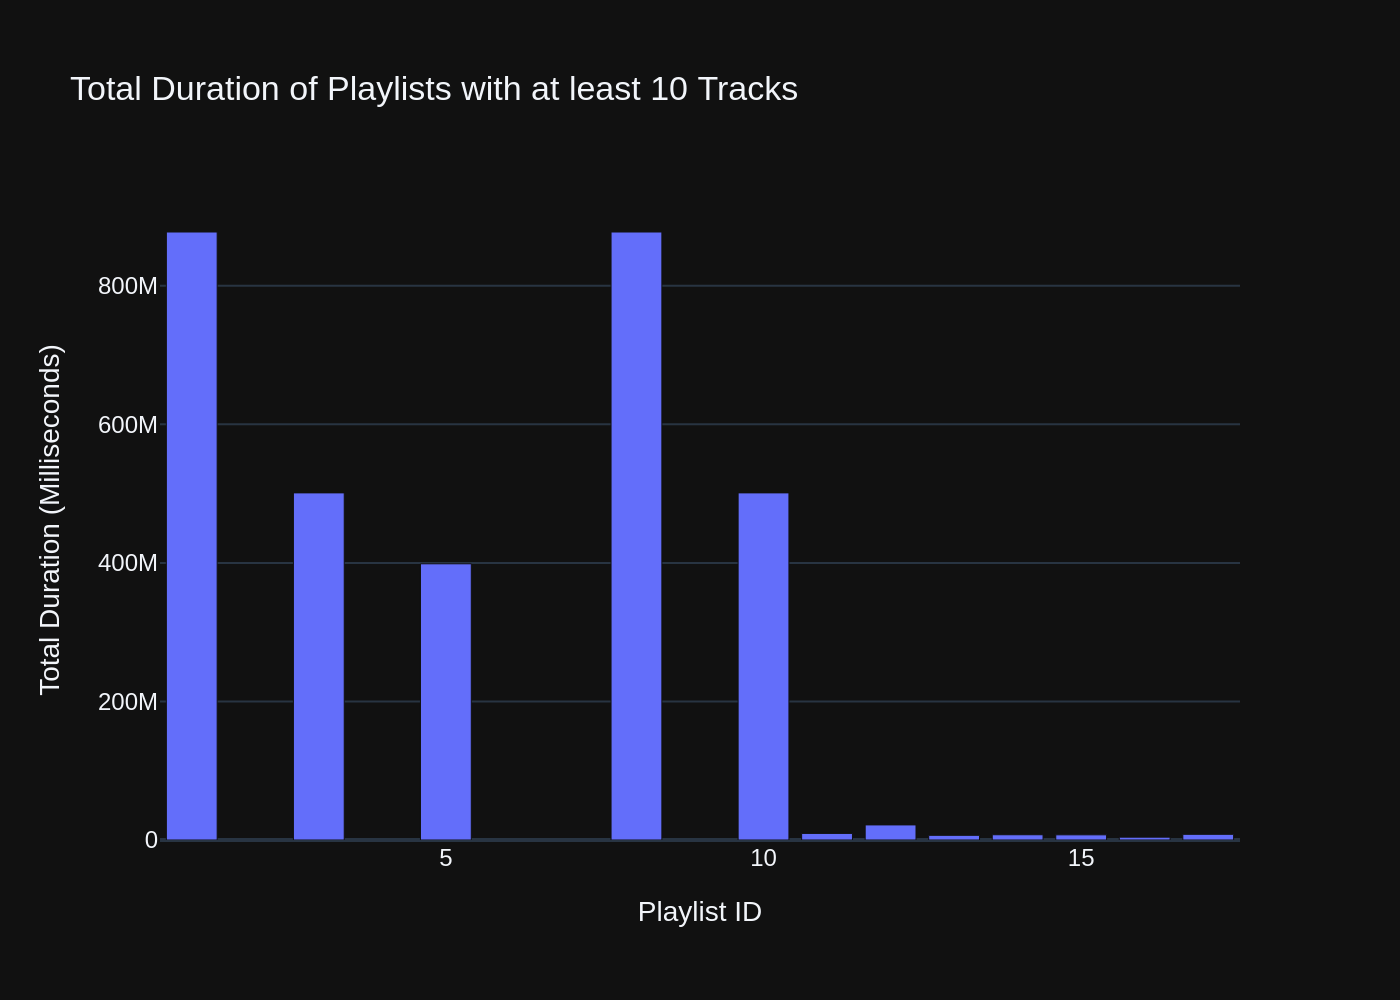





# QUESTION  - 25:  Identify artists who have albums with tracks appearing in multiple genres:


Using model gpt-4o-mini for 1373.0 tokens (approx)

[( EXTRACTED SQL )]
SELECT DISTINCT artists.Name AS ArtistName 
FROM artists 
JOIN albums ON artists.ArtistId = albums.ArtistId 
JOIN tracks ON albums.AlbumId = tracks.AlbumId 
JOIN genres ON tracks.GenreId = genres.GenreId 
GROUP BY artists.ArtistId 
HAVING COUNT(DISTINCT genres.GenreId) > 1;


[( <SQL> )]
generated SQL statement



SELECT DISTINCT artists.Name AS ArtistName 
FROM artists 
JOIN albums ON artists.ArtistId = albums.ArtistId 
JOIN tracks ON albums.AlbumId = tracks.AlbumId 
JOIN genres ON tracks.GenreId = genres.GenreId 
GROUP BY artists.ArtistId 
HAVING COUNT(DISTINCT genres.GenreId) > 1;


[( <DataFrame> )]
queried dataframe



,ArtistName
0,Antônio Carlos Jobim
1,Audioslave
2,Various Artists
3,Gilberto Gil
4,Eric Clapton
5,Faith No More
6,Foo Fighters
7,Guns N' Roses
8,Iron Maiden
9,Jamiroquai


Using model gpt-4o-mini for 234.25 tokens (approx)

[( <Python> )]
generated Plotly code



import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=len(df),
        title={"text": "Number of Artists with Albums in Multiple Genres"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = px.bar(df, x='ArtistName', title='Artists with Albums in Multiple Genres')

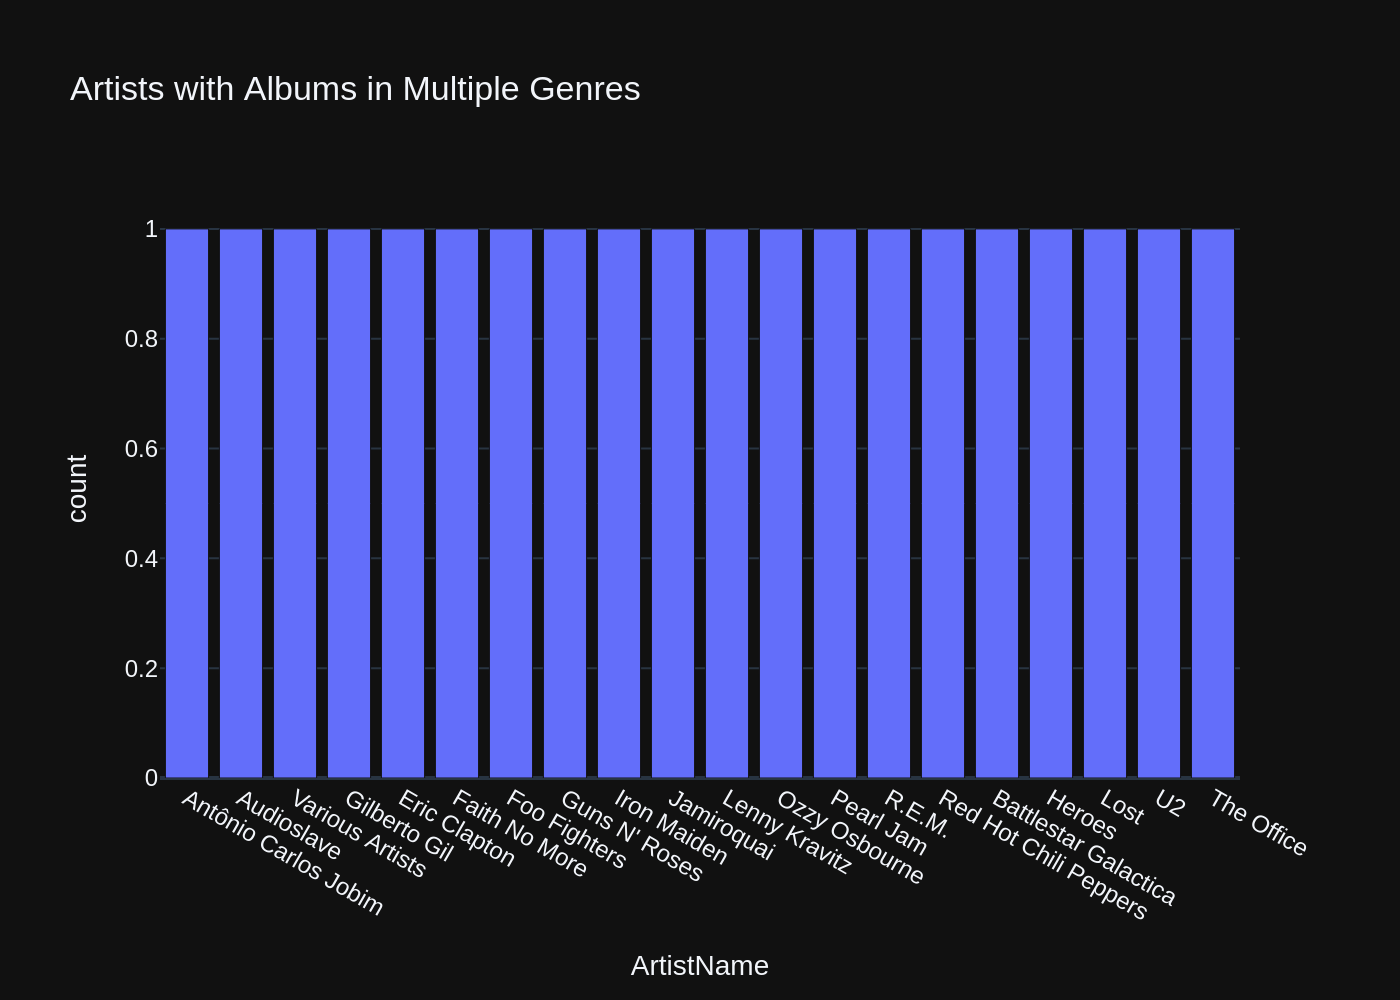

In [18]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

## Check completion time

In [19]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'gpt-4o-mini' 
 took 98 sec
 run on 'ducklover1' 
 at 20241122-233204


In [20]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

'training_data-gpt-4o-mini-98s-ducklover1-20241122-233204.csv'

### Save training data

In [21]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,question,content,training_data_type
0,092be065-5a42-591f-9079-33f77a74fc31-sql,Find the top 5 most expensive tracks (based on...,SELECT * FROM tracks ORDER BY UnitPrice DESC L...,sql
1,15aac60e-cb46-5006-b812-57ce43a744d4-sql,"Find all tracks with a name containing ""What"" ...",SELECT * FROM tracks WHERE Name LIKE '%What%' ...,sql
2,1a6d0ce7-c5c3-5622-9a44-d19db18288fe-sql,Get all playlists containing at least 10 track...,"SELECT playlist_track.PlaylistId, SUM(tracks.M...",sql
3,1cdc61ff-fe82-5418-9417-25f0ccfcff02-sql,Get the total number of invoices for each cust...,"SELECT CustomerId, COUNT(*) AS InvoiceCount \n...",sql
4,22e31cff-a161-587a-bf95-222e94413bdf-sql,List all employees and their reporting manager...,SELECT e.FirstName || ' ' || e.LastName AS Emp...,sql
5,2438c4b9-c85c-550f-b7f3-42ebc30cfefa-sql,Get the average invoice total for each customer:,"SELECT CustomerId, AVG(Total) AS AverageInvoic...",sql
6,2dfa865d-7ee3-5bef-aec3-2e7d19476ef5-sql,what are the top 5 countries that customers co...,"SELECT BillingCountry, COUNT(*) AS CustomerCou...",sql
7,54a9bc98-ff0e-5f0a-9fa4-146db29c6c3a-sql,Find the customer who bought the most albums i...,"SELECT invoices.CustomerId, SUM(invoice_items....",sql
8,6a1e5893-7491-5d66-a493-12e763d8ef70-sql,Identify artists who have albums with tracks a...,SELECT DISTINCT artists.Name AS ArtistName \nF...,sql
9,855c29ff-4cf2-5c2b-975b-de6a6b07b453-sql,Find all invoices since 2010 and the total amo...,SELECT * FROM invoices WHERE InvoiceDate >= '2...,sql


In [22]:
df_training_data.to_csv(file_csv, index=False)